<a href="https://colab.research.google.com/github/smartaces/opencite/blob/main/opencite_starter_cookbook_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

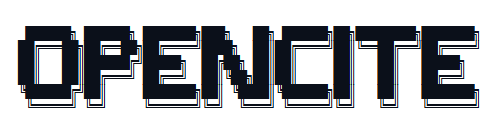

# Welcome! Let's Explore AI Citations Together!
Welcome to the OpenCite Cookbook! This notebook is a guided tour that helps you see exactly where AI models like ChatGPT get their information. We'll walk you through, step-by-step, how to run searches and analyze the websites and articles the AI cites as its sources.

Think of this notebook as a recipe. You'll run "cells" (the blocks of code below) one by one. Each cell has a description like this one to explain what it does. Just follow the steps in order to begin your analysis!

# Connect and Learn More
For more information about this open source project visit: [OpenCite.ai](https://opensite.ai)

# Check out the full Github repo and leave a star:
https://github.com/smartaces/opencite/tree/main


# Step 1: Install Necessary Bits and Bobs
First, let's get your environment ready. This cell quickly installs a few key software components that the notebook needs to run searches, create interactive controls, and build reports.

You only need to run this cell once each time you start a new session.


In [ ]:
# Run once per runtime to install dependencies
%pip install --quiet openai rich python-dotenv ipywidgets plotly


# Step 2: Set Your OpenAI API Key
To ask the AI questions, this notebook needs to connect to OpenAI using an API key. An API key is like a password that gives you access.

**Goal:** Allow the notebook to communicate with OpenAI.
**Action:**
1.  Get your API key from OpenAI's website: [https://platform.openai.com/api-keys](https://platform.openai.com/api-keys).
2.  In the file browser, copy the `.env.example` file and rename the copy to `.env`.
3.  Paste your key into the `.env` file and save it.
4.  Run this cell.

*Note: Running searches uses the OpenAI API, which may have associated costs. You can set usage limits in your OpenAI account dashboard.*


In [ ]:
import os
from pathlib import Path

from dotenv import load_dotenv

try:
    from google.colab import userdata  # type: ignore
except ImportError:  # Not running inside Colab
    userdata = None

load_dotenv()


def configure_openai(secret_name: str = "openai_key", env_var: str = "OPENAI_API_KEY") -> None:
    """Load the OpenAI API key from Colab secrets, .env, or environment vars."""
    key = None

    if userdata is not None:
        try:
            key = userdata.get(secret_name)
            if key:
                print(f"✅ Loaded OpenAI key from Colab secret '{secret_name}'.")
        except Exception as exc:  # pragma: no cover - best effort logging
            print(f"⚠️ Could not read Colab secret '{secret_name}': {exc}")

    if not key:
        key = os.getenv(env_var)
        if key:
            print(f"✅ Loaded OpenAI key from environment variable '{env_var}'.")

    if not key:
        raise RuntimeError(
            "OpenAI API key not found. In Colab, add it via Settings → Secrets as 'openai_key'. "
            "Locally, set OPENAI_API_KEY in a .env file or export it before running this cell."
        )

    os.environ[env_var] = key
    print("🔐 OPENAI_API_KEY is configured for this session.")


configure_openai()


# Step 3: Choose a Project Folder
All the data, logs, and reports you generate need a place to live. This cell will ask you to choose a central "project folder" (also called a workspace) where everything will be saved.

If you are using Google Colab, selecting a folder in your Google Drive is a great way to make sure your work is saved.


In [ ]:
import os
import sys
from pathlib import Path

try:
    from google.colab import drive  # type: ignore
except ImportError:  # Not running inside Colab
    drive = None

IN_COLAB = "google.colab" in sys.modules


def configure_workspace(default_folder: str = "opencite_workspace") -> None:
    """Guide the user through selecting a workspace directory."""
    global WORKSPACE_ROOT

    if IN_COLAB:
        print("Select where you want to store project files:")
        print("  1 - Temporary Colab storage (/content)")
        print("  2 - Google Drive (/content/drive/MyDrive)")
        print("  3 - Custom absolute path")
        choice = input("Enter 1, 2, or 3 [default 1]: ").strip() or "1"

        if choice == "2":
            if drive is None:
                raise RuntimeError("google.colab.drive is unavailable in this environment.")
            mount_point = "/content/drive"
            if not Path(mount_point).exists() or not os.path.ismount(mount_point):
                print("🔌 Mounting Google Drive...")
                drive.mount(mount_point)
            base_path = Path(mount_point) / "MyDrive"
        elif choice == "3":
            base_input = input("Enter the full path you want to use: ").strip()
            if not base_input:
                raise RuntimeError("No path provided.")
            base_path = Path(base_input).expanduser()
        else:
            base_path = Path("/content")
    else:
        default_base = Path.cwd()
        prompt = f"Enter workspace path [{default_base}]: "
        base_input = input(prompt).strip()
        base_path = Path(base_input).expanduser() if base_input else default_base

    folder_name = input(f"Folder name inside {base_path} [{default_folder}]: ").strip() or default_folder
    workspace_path = base_path / folder_name
    workspace_path.mkdir(parents=True, exist_ok=True)

    WORKSPACE_ROOT = workspace_path.resolve()
    os.environ["WORKSPACE_ROOT"] = str(WORKSPACE_ROOT)
    print(f"📁 Workspace ready at: {WORKSPACE_ROOT}")


configure_workspace()


# Step 4: Organize Your Project Folder's Structure
Now that you've chosen a main project folder, this cell will create a few subfolders inside it to keep your work organized (for example, a `csv_output` folder for your reports).

This ensures the notebook always knows where to find and save your files.


In [ ]:
import json
import os
from pathlib import Path

if "WORKSPACE_ROOT" in globals():
    workspace_root = Path(WORKSPACE_ROOT)
else:
    env_root = os.environ.get("WORKSPACE_ROOT")
    if not env_root:
        raise RuntimeError("Workspace not configured. Run the previous cell first to select a location.")
    workspace_root = Path(env_root)

workspace_root = workspace_root.expanduser().resolve()
os.environ["WORKSPACE_ROOT"] = str(workspace_root)

subfolders = {
    "search_results": workspace_root / "search_results",
    "extracted_raw": workspace_root / "extracted_raw",
    "csv_output": workspace_root / "csv_output",
    "grabbed": workspace_root / "grabbed",
    "terms_lists": workspace_root / "terms_lists",
    "logs": workspace_root / "logs"
}

for path in subfolders.values():
    path.mkdir(parents=True, exist_ok=True)

PATHS = {name: str(path) for name, path in subfolders.items()}

config = {
    "workspace_root": str(workspace_root),
    "paths": PATHS
}

config_path = workspace_root / "workspace_config.json"
with open(config_path, "w", encoding="utf-8") as fp:
    json.dump(config, fp, indent=2)

os.environ["WORKSPACE_CONFIG"] = str(config_path)

print(f"📁 Workspace root: {workspace_root}")
for name, path in PATHS.items():
    print(f"  • {name}: {path}")
print(f"🗂️ Config saved to: {config_path}")
print("ℹ️ Later cells: from pathlib import Path; PATHS.get('csv_output') etc.")


# Step 5: Automatically Save Files in the Right Place
This is a small but mighty helper! Once you run this cell, the notebook will automatically save any files you create (like CSV reports) into the correct subfolder within your project folder.

It's a "set it and forget it" step that keeps your workspace tidy without you having to worry about it.


In [ ]:
import builtins
import json
import os
from pathlib import Path

CONFIG_PATH = Path(os.environ.get("WORKSPACE_CONFIG", ""))
if not CONFIG_PATH.is_file():
    raise RuntimeError("workspace_config.json not found. Run the setup cells first.")

with open(CONFIG_PATH, "r", encoding="utf-8") as fp:
    workspace_config = json.load(fp)

WORKSPACE_ROOT = Path(workspace_config["workspace_root"])
PATHS = {key: Path(value) for key, value in workspace_config["paths"].items()}

_original_open = builtins.open


def smart_open(file, *args, **kwargs):
    """Resolve relative file paths into the workspace automatically."""
    file_path = Path(file)
    if not file_path.is_absolute():
        for prefix in PATHS.values():
            # If the path already includes a known folder name, leave as-is
            pass
        # Default: put file under workspace root
        file_path = WORKSPACE_ROOT / file_path
    file_path.parent.mkdir(parents=True, exist_ok=True)
    return _original_open(file_path, *args, **kwargs)


builtins.open = smart_open

print("✅ Smart file handling enabled. Relative paths are rooted at:")
print(f"   {WORKSPACE_ROOT}")
for name, path in PATHS.items():
    print(f"   • {name}: {path}")


# Step 6: Enable Searches from Specific Locations
Did you know that search results can change for users in different cities or countries? This cell prepares a tool that lets you simulate searches from specific locations.

After running this, you'll be able to use the location feature in the search interfaces below.


In [ ]:
def format_location(country: str = "US", city: str = "New York", region: str = "New York") -> dict:
    """Return a location dict compatible with OpenAI web search requests."""
    return {
        "country": country,
        "city": city,
        "region": region
    }


print("✅ format_location helper ready (use it when passing user_location to search calls).")


# Step 7: Get the AI Search Agent Ready
It's time to prepare the "brains" of our operation. This cell initializes the AI Search Agent, which is responsible for sending your questions to the model and retrieving the answers along with their cited sources.

Run this to bring the agent online.


In [ ]:
from typing import Any, Dict, List, Optional

from openai import OpenAI

client = OpenAI()


class OpenAISearchAgent:
    """OpenAI Web Search Agent using the Responses API."""

    def __init__(self, client: OpenAI, model: str = "gpt-5"):
        self.client = client
        self.model = model
        self.conversation_history: List[Dict[str, Any]] = []
        self.last_response_id: Optional[str] = None  # For GPT-5 reasoning continuity

    def search(
        self,
        query: str,
        search_context_size: str = "medium",
        user_location: Optional[Dict[str, str]] = None,
        force_search: bool = False,
        reasoning_effort: str = "low",
        verbosity: str = "medium",
        use_previous_reasoning: bool = True,
    ) -> Dict[str, Any]:
        tools: List[Dict[str, Any]] = []
        web_search_config: Dict[str, Any] = {"type": "web_search_preview"}

        if self.model not in ["o3", "o3-pro", "o4-mini"]:
            web_search_config["search_context_size"] = search_context_size

        if user_location:
            web_search_config["user_location"] = {
                "type": "approximate",
                **user_location,
            }

        tools.append(web_search_config)

        request_params: Dict[str, Any] = {
            "model": self.model,
            "tools": tools,
            "input": query,
        }

        if self.model.startswith("gpt-5"):
            if reasoning_effort == "minimal":
                reasoning_effort = "low"

            request_params["reasoning"] = {"effort": reasoning_effort}
            request_params["text"] = {"verbosity": verbosity}

            if use_previous_reasoning and self.last_response_id:
                request_params["previous_response_id"] = self.last_response_id

        if force_search:
            request_params["tool_choice"] = {"type": "web_search_preview"}

        try:
            response = self.client.responses.create(**request_params)
            if hasattr(response, "id"):
                self.last_response_id = response.id
            self.conversation_history.append({"query": query, "response": response})
            return response
        except Exception as exc:  # pragma: no cover - API/network errors
            return {"error": str(exc)}

    def extract_text_response(self, response: Any) -> str:
        try:
            if isinstance(response, dict) and "error" in response:
                return f"Error: {response['error']}"
            if hasattr(response, "output_text"):
                return response.output_text
            if hasattr(response, "output"):
                for output in response.output:
                    if getattr(output, "type", None) == "message" and hasattr(output, "content"):
                        for item in output.content:
                            if getattr(item, "type", None) == "output_text":
                                return getattr(item, "text", "")
                    elif isinstance(output, dict) and output.get("type") == "message":
                        for item in output.get("content", []):
                            if item.get("type") == "output_text":
                                return item.get("text", "")
            return "No text response found"
        except Exception as exc:
            return f"Error extracting response: {exc}"

    def extract_citations(self, response: Any) -> List[Dict[str, Any]]:
        citations: List[Dict[str, Any]] = []
        try:
            if hasattr(response, "output"):
                for output in response.output:
                    if getattr(output, "type", None) == "message" and hasattr(output, "content"):
                        for item in output.content:
                            if getattr(item, "type", None) == "output_text":
                                annotations = getattr(item, "annotations", [])
                                for ann in annotations:
                                    if getattr(ann, "type", None) == "url_citation":
                                        citations.append({
                                            "url": getattr(ann, "url", ""),
                                            "title": getattr(ann, "title", ""),
                                        })
                    elif isinstance(output, dict) and output.get("type") == "message":
                        for item in output.get("content", []):
                            if item.get("type") == "output_text":
                                for ann in item.get("annotations", []):
                                    if ann.get("type") == "url_citation":
                                        citations.append({
                                            "url": ann.get("url", ""),
                                            "title": ann.get("title", ""),
                                        })
        except Exception:
            pass
        return citations

    def get_search_actions(self, response: Any) -> List[Dict[str, Any]]:
        actions: List[Dict[str, Any]] = []
        try:
            if hasattr(response, "output"):
                for output in response.output:
                    if getattr(output, "type", None) == "web_search_call":
                        actions.append({
                            "id": getattr(output, "id", ""),
                            "status": getattr(output, "status", ""),
                            "action": getattr(output, "action", {}),
                        })
                    elif isinstance(output, dict) and output.get("type") == "web_search_call":
                        actions.append({
                            "id": output.get("id", ""),
                            "status": output.get("status", ""),
                            "action": output.get("action", {}),
                        })
        except Exception:
            pass
        return actions

    def clear_history(self) -> None:
        self.conversation_history = []
        self.last_response_id = None
        print("🗑️ Conversation history cleared")


search_agent = OpenAISearchAgent(client, model="gpt-5")
print(f"🤖 Search Agent initialized with {search_agent.model}!")
print("💡 Tip: GPT-5 reasoning chains persist across turns when previous_response_id is set.")


def print_search_result(response, show_citations: bool = True, show_actions: bool = False) -> None:
    """Pretty-print a response from the search agent."""
    text = search_agent.extract_text_response(response)

    print("=" * 80)
    print("📝 RESPONSE:")
    print("=" * 80)
    print(text)
    print()

    if show_citations:
        citations = search_agent.extract_citations(response)
        if citations:
            print("=" * 80)
            print("🔗 CITATIONS:")
            print("=" * 80)
            for i, cite in enumerate(citations, 1):
                print(f"{i}. {cite.get('title', 'Untitled')}")
                print(f"   URL: {cite.get('url', 'Unknown')}")
                print()

    if show_actions:
        actions = search_agent.get_search_actions(response)
        if actions:
            print("=" * 80)
            print("🔍 SEARCH ACTIONS:")
            print("=" * 80)
            for action in actions:
                print(f"ID: {action.get('id', '')}")
                print(f"Status: {action.get('status', '')}")
                if action.get('action'):
                    print(f"Action details: {action['action']}")
                print()


# Step 8: Prepare the Tool that Logs Your Results
To analyze your search results, you first need to record them. This cell gets the data logging tool ready. It will automatically save every search you run into organized data files (CSVs), which are used to build the final analysis reports.


In [ ]:
from __future__ import annotations

import json
import uuid
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Iterable, Optional

import pandas as pd


class ReportHelper:
    """Consistent logging/serialization for notebook cells."""

    DETAIL_COLUMNS: Iterable[str] = [
        "row_timestamp",
        "scenario",
        "execution_id",
        "unit_id",
        "turn_or_run",
        "role",
        "model",
        "persona_profile",
        "persona_model",
        "query_or_topic",
        "message_text",
        "citation_rank",
        "citation_title",
        "citation_url",
        "domain",
        "context",
        "reasoning",
        "location_country",
        "location_city",
        "location_region",
        "response_file",
    ]

    def __init__(self, scenario: str, paths: Dict[str, Any]):
        self.scenario = scenario
        self.paths = paths
        self.output_dir = Path(paths["csv_output"]).expanduser().resolve()
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.raw_dir = self.output_dir / "raw"
        self.raw_dir.mkdir(parents=True, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.execution_id = f"{timestamp}_{uuid.uuid4().hex[:8]}"
        self.start_ts = datetime.now().isoformat()
        self._detail_rows: list[Dict[str, Any]] = []

    # ------------------------------------------------------------------
    def save_raw_response(self, label: str, response: Any) -> Path:
        """Persist raw response JSON and return the file path."""
        raw_path = self.raw_dir / f"{self.scenario}_{self.execution_id}_{label}.json"
        try:
            payload = response.model_dump()  # type: ignore[attr-defined]
        except AttributeError:
            payload = response
        raw_path.write_text(json.dumps(payload, indent=2, default=str))
        return raw_path

    # ------------------------------------------------------------------
    def add_detail_row(self, **row: Any) -> None:
        """Append a single detail row (with default metadata) to the log."""
        row.setdefault("row_timestamp", datetime.now().isoformat())
        row.setdefault("scenario", self.scenario)
        row.setdefault("execution_id", self.execution_id)
        for column in self.DETAIL_COLUMNS:
            row.setdefault(column, None)
        self._detail_rows.append(row)

    # ------------------------------------------------------------------
    def write_detail_csv(self) -> Path:
        """Flush accumulated detail rows to CSV and return the path."""
        detail_path = self.output_dir / f"{self.scenario}_detail_{self.execution_id}.csv"
        df = pd.DataFrame(self._detail_rows)
        # Reorder columns if possible
        cols = [c for c in self.DETAIL_COLUMNS if c in df.columns]
        rest = [c for c in df.columns if c not in cols]
        df = df[cols + rest]
        df.to_csv(detail_path, index=False)
        return detail_path

    # ------------------------------------------------------------------
    def write_summary_csv(self, summary_row: Dict[str, Any]) -> Path:
        """Write a one-row summary CSV."""
        summary_row.setdefault("scenario", self.scenario)
        summary_row.setdefault("execution_id", self.execution_id)
        summary_row.setdefault("timestamp", datetime.now().isoformat())
        summary_path = self.output_dir / f"{self.scenario}_summary_{self.execution_id}.csv"
        pd.DataFrame([summary_row]).to_csv(summary_path, index=False)
        return summary_path


# Search Mode 1: Ask a Single Question
Use this mode for a quick, one-off search. It's the fastest way to ask a question and see the sources behind the answer. Simply type your query, choose your settings, and get an immediate report on the citations.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from urllib.parse import urlparse
from pathlib import Path
import json
import os

if 'PATHS' not in globals():
    config_path = Path(os.environ.get('WORKSPACE_CONFIG', ''))
    if not config_path.is_file():
        raise RuntimeError('Workspace not configured. Run the setup cells first.')
    with open(config_path, 'r', encoding='utf-8') as fp:
        workspace_config = json.load(fp)
    PATHS = {k: Path(v) for k, v in workspace_config['paths'].items()}

if 'search_agent' not in globals():
    raise RuntimeError('Search agent not initialized. Run the agent cell first.')

if 'ReportHelper' not in globals():
    raise RuntimeError('ReportHelper not defined. Run the reporting helper cell first.')

# --- Query & model controls ---
query_input = widgets.Textarea(
    value="What is the best value smartphone in 2026 for $1000",
    description="Query:",
    layout=widgets.Layout(width="100%", height="80px"),
    placeholder="Type your search question..."
)

context_dropdown = widgets.Dropdown(
    options=[("Low", "low"), ("Medium", "medium"), ("High", "high")],
    value="medium",
    description="Context:",
)

reasoning_dropdown = widgets.Dropdown(
    options=[("Low", "low"), ("Medium", "medium"), ("High", "high")],
    value="low",
    description="Reasoning:",
)

# --- Location controls ---
location_toggle = widgets.Checkbox(value=False, description="Apply location bias")

location_presets = widgets.Dropdown(
    options=[
        ("US · New York", "us_ny"),
        ("UK · London", "uk_london"),
        ("US · San Francisco", "us_sf"),
        ("France · Paris", "fr_paris"),
        ("Germany · Berlin", "de_berlin"),
        ("Custom", "custom"),
    ],
    value="us_ny",
    description="Preset:",
    disabled=True,
)

custom_country = widgets.Text(value="US", description="Country:", disabled=True)
custom_city = widgets.Text(value="New York", description="City:", disabled=True)
custom_region = widgets.Text(value="New York", description="Region:", disabled=True)

run_button = widgets.Button(description="Run Search", button_style="primary", icon="search")
output = widgets.Output()

preset_map = {
    "us_ny": ("US", "New York", "New York"),
    "uk_london": ("GB", "London", "London"),
    "us_sf": ("US", "San Francisco", "California"),
    "fr_paris": ("FR", "Paris", "Île-de-France"),
    "de_berlin": ("DE", "Berlin", "Berlin"),
}


def update_location_visibility(change=None):
    enabled = location_toggle.value
    location_presets.disabled = not enabled
    is_custom = enabled and location_presets.value == "custom"
    for widget in (custom_country, custom_city, custom_region):
        widget.disabled = not is_custom


def get_location_dict():
    if not location_toggle.value:
        return None
    if location_presets.value != "custom":
        country, city, region = preset_map[location_presets.value]
    else:
        country = custom_country.value or "US"
        city = custom_city.value or "New York"
        region = custom_region.value or city
    return format_location(country=country, city=city, region=region)


location_toggle.observe(update_location_visibility, "value")
location_presets.observe(update_location_visibility, "value")
update_location_visibility()


def run_single_search(_):
    query = query_input.value.strip()
    with output:
        clear_output()
        if not query:
            print("⚠️ Please enter a query before running the search.")
            return
        user_location = get_location_dict()
        location_note = (
            f"📍 Location bias: {user_location}" if user_location else "📍 Location bias: none"
        )
        reporter = ReportHelper('single_run', PATHS)
        execution_id = reporter.execution_id
        model_name = getattr(search_agent, 'model', 'unknown')
        print(f"▶ Execution ID: {execution_id}")
        print("⏳ Running search, hang tight...\n")
        reporter.add_detail_row(
            unit_id=f"{execution_id}_query",
            turn_or_run=0,
            role='user',
            model=None,
            query_or_topic=query,
            message_text=query,
            citation_rank=None,
            citation_title=None,
            citation_url=None,
            domain=None,
            context=context_dropdown.value,
            reasoning=reasoning_dropdown.value,
            location_country=user_location['country'] if user_location else None,
            location_city=user_location['city'] if user_location else None,
            location_region=user_location['region'] if user_location else None,
            response_file=None,
        )
        response = search_agent.search(
            query,
            search_context_size=context_dropdown.value,
            reasoning_effort=reasoning_dropdown.value,
            verbosity="medium",
            user_location=user_location,
        )
        raw_path = reporter.save_raw_response("run", response)
        text = search_agent.extract_text_response(response)
        citations = search_agent.extract_citations(response) or []
        if citations:
            for rank, cite in enumerate(citations, 1):
                url = cite.get('url', '')
                domain = urlparse(url).netloc.replace('www.', '') if url else ''
                reporter.add_detail_row(
                    unit_id=f"{execution_id}_advisor_{rank}",
                    turn_or_run=1,
                    role='AI System',
                    model=model_name,
                    query_or_topic=query,
                    message_text=text,
                    citation_rank=rank,
                    citation_title=cite.get('title', ''),
                    citation_url=url,
                    domain=domain,
                    context=context_dropdown.value,
                    reasoning=reasoning_dropdown.value,
                    location_country=user_location['country'] if user_location else None,
                    location_city=user_location['city'] if user_location else None,
                    location_region=user_location['region'] if user_location else None,
                    response_file=str(raw_path),
                )
        else:
            reporter.add_detail_row(
                unit_id=f"{execution_id}_advisor_1",
                turn_or_run=1,
                role='AI System',
                model=model_name,
                query_or_topic=query,
                message_text=text,
                citation_rank=None,
                citation_title=None,
                citation_url=None,
                domain=None,
                context=context_dropdown.value,
                reasoning=reasoning_dropdown.value,
                location_country=user_location['country'] if user_location else None,
                location_city=user_location['city'] if user_location else None,
                location_region=user_location['region'] if user_location else None,
                response_file=str(raw_path),
            )
        detail_path = reporter.write_detail_csv()
        summary_row = {
            'model': model_name,
            'query': query,
            'context': context_dropdown.value,
            'reasoning': reasoning_dropdown.value,
            'location_country': user_location['country'] if user_location else None,
            'location_city': user_location['city'] if user_location else None,
            'location_region': user_location['region'] if user_location else None,
            'total_citations': len(citations),
            'unique_citation_urls': len({c.get('url') for c in citations if c.get('url')}) if citations else 0,
            'unique_domains': len({urlparse(c.get('url', '')).netloc.replace('www.', '') for c in citations if c.get('url')}) if citations else 0,
        }
        summary_path = reporter.write_summary_csv(summary_row)
        clear_output()
        print(f"🔍 Query: {query}\n{location_note}\n")
        print_search_result(response)
        print(f"\n💾 Detail CSV: {detail_path}")
        print(f"💾 Summary CSV: {summary_path}")


run_button.on_click(run_single_search)

location_box = widgets.VBox([
    location_toggle,
    location_presets,
    widgets.HBox([custom_country, custom_city, custom_region]),
])

controls = widgets.VBox([
    query_input,
    widgets.HBox([context_dropdown, reasoning_dropdown]),
    location_box,
    run_button,
])

display(widgets.VBox([controls, output]))


# Search Mode 2: Test How Often a Source is Cited
Does the AI cite the same sources every time for the same question? This mode helps you find out. It runs the same prompt multiple times so you can see how much the results vary. This is great for understanding how stable or consistent a source's ranking is.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
from pathlib import Path
from urllib.parse import urlparse
import pandas as pd
import json
import os
import re

if 'PATHS' not in globals():
    config_path = Path(os.environ.get('WORKSPACE_CONFIG', ''))
    if not config_path.is_file():
        raise RuntimeError('Workspace not configured. Run the setup cells first.')
    with open(config_path, 'r', encoding='utf-8') as fp:
        workspace_config = json.load(fp)
    PATHS = {k: Path(v) for k, v in workspace_config['paths'].items()}

if 'search_agent' not in globals():
    raise RuntimeError('Search agent not initialized. Run the agent cell first.')

if 'ReportHelper' not in globals():
    raise RuntimeError('ReportHelper not defined. Run the reporting helper cell first.')

query_input_multi = widgets.Textarea(
    value="Compare Samsung S25 vs Google Pixel",
    description="Query:",
    layout=widgets.Layout(width="100%", height="80px"),
)

context_dropdown_multi = widgets.Dropdown(
    options=[("Low", "low"), ("Medium", "medium"), ("High", "high")],
    value="medium",
    description="Context:",
)

reasoning_dropdown_multi = widgets.Dropdown(
    options=[("Low", "low"), ("Medium", "medium"), ("High", "high")],
    value="low",
    description="Reasoning:",
)

run_count_dropdown = widgets.Dropdown(
    options=[("1 run", 1), ("3 runs", 3), ("5 runs", 5), ("10 runs", 10), ("20 runs", 20)],
    value=3,
    description="# Runs:",
)

location_toggle_multi = widgets.Checkbox(value=False, description="Apply location bias")
location_presets_multi = widgets.Dropdown(
    options=[
        ("US · New York", "us_ny"),
        ("UK · London", "uk_london"),
        ("US · San Francisco", "us_sf"),
        ("France · Paris", "fr_paris"),
        ("Germany · Berlin", "de_berlin"),
        ("Custom", "custom"),
    ],
    value="us_ny",
    description="Preset:",
    disabled=True,
)
custom_country_multi = widgets.Text(value="US", description="Country:", disabled=True)
custom_city_multi = widgets.Text(value="New York", description="City:", disabled=True)
custom_region_multi = widgets.Text(value="New York", description="Region:", disabled=True)

run_multi_button = widgets.Button(description="Run Multi-Search", button_style="primary", icon="refresh")
output_multi = widgets.Output()

preset_map_multi = {
    "us_ny": ("US", "New York", "New York"),
    "uk_london": ("GB", "London", "London"),
    "us_sf": ("US", "San Francisco", "California"),
    "fr_paris": ("FR", "Paris", "Île-de-France"),
    "de_berlin": ("DE", "Berlin", "Berlin"),
}


def update_location_multi(change=None):
    enabled = location_toggle_multi.value
    location_presets_multi.disabled = not enabled
    is_custom = enabled and location_presets_multi.value == "custom"
    for widget in (custom_country_multi, custom_city_multi, custom_region_multi):
        widget.disabled = not is_custom


def get_location_multi():
    if not location_toggle_multi.value:
        return None
    if location_presets_multi.value != "custom":
        country, city, region = preset_map_multi[location_presets_multi.value]
    else:
        country = custom_country_multi.value or "US"
        city = custom_city_multi.value or "New York"
        region = custom_region_multi.value or city
    return format_location(country=country, city=city, region=region)


location_toggle_multi.observe(update_location_multi, "value")
location_presets_multi.observe(update_location_multi, "value")
update_location_multi()


def slugify(text: str, length: int = 60) -> str:
    slug = re.sub(r"[^a-z0-9]+", "_", text.lower()).strip("_")
    return slug[:length] or "query"


def run_multi(_):
    query = query_input_multi.value.strip()
    run_count = run_count_dropdown.value
    user_location = get_location_multi()

    with output_multi:
        clear_output()
        if not query:
            print("⚠️ Please enter a query before running the analysis.")
            return

        reporter = ReportHelper('multi_run', PATHS)
        execution_id = reporter.execution_id
        model_name = getattr(search_agent, 'model', 'unknown')

        print(f"▶ Execution ID: {execution_id}")
        print(f"▶ Running {run_count} searches for: {query}")
        if user_location:
            print(f"📍 Location bias: {user_location}\n")
        else:
            print("📍 Location bias: none\n")

        summaries = []

        for idx in range(1, run_count + 1):
            run_id = f"{execution_id}_run_{idx}"
            print(f"--- Run {idx}/{run_count} ---")
            print("⏳ Requesting response...\n")
            response = search_agent.search(
                query,
                search_context_size=context_dropdown_multi.value,
                reasoning_effort=reasoning_dropdown_multi.value,
                verbosity="medium",
                user_location=user_location,
            )

            raw_path = reporter.save_raw_response(f"run_{idx}", response)
            print_search_result(response)
            print()

            text = search_agent.extract_text_response(response)
            citations = search_agent.extract_citations(response)
            citation_urls = []

            if citations:
                for rank, cite in enumerate(citations, 1):
                    url = cite.get('url', '')
                    domain = urlparse(url).netloc.replace('www.', '') if url else ''
                    reporter.add_detail_row(
                        unit_id=run_id,
                        turn_or_run=idx,
                        role='AI System',
                        model=model_name,
                        query_or_topic=query,
                        message_text=text,
                        citation_rank=rank,
                        citation_title=cite.get('title', ''),
                        citation_url=url,
                        domain=domain,
                        context=context_dropdown_multi.value,
                        reasoning=reasoning_dropdown_multi.value,
                        location_country=user_location['country'] if user_location else None,
                        location_city=user_location['city'] if user_location else None,
                        location_region=user_location['region'] if user_location else None,
                        response_file=str(raw_path),
                    )
                    if url:
                        citation_urls.append(url)
            else:
                reporter.add_detail_row(
                    unit_id=run_id,
                    turn_or_run=idx,
                    role='AI System',
                    model=model_name,
                    query_or_topic=query,
                    message_text=text,
                    citation_rank=None,
                    citation_title=None,
                    citation_url=None,
                    domain=None,
                    context=context_dropdown_multi.value,
                    reasoning=reasoning_dropdown_multi.value,
                    location_country=user_location['country'] if user_location else None,
                    location_city=user_location['city'] if user_location else None,
                    location_region=user_location['region'] if user_location else None,
                    response_file=str(raw_path),
                )

            summaries.append({'run': idx, 'citations': citation_urls})
            print(f"Run {idx} complete — {len(citation_urls)} citations captured.\n")

        detail_path = reporter.write_detail_csv()

        df = pd.DataFrame(reporter._detail_rows)
        df_valid = df.dropna(subset=['citation_url'])
        citation_sets = [tuple(sorted(summary['citations'])) for summary in summaries]
        unique_sets = len(set(citation_sets))
        consistency_pct = 100.0 if len(citation_sets) <= 1 else 100 * (1 - (unique_sets - 1) / len(citation_sets))
        domain_counts = df_valid['domain'].value_counts().head(5)

        print("=== Consistency Summary ===")
        print(f"Runs executed: {run_count}")
        print(f"Unique citation sets: {unique_sets}")
        print(f"Citation consistency score: {consistency_pct:.1f}%\n")
        if not domain_counts.empty:
            print("Top cited domains:")
            for domain, count in domain_counts.items():
                print(f"  • {domain}: {count}")

        summary_row = {
            'model': model_name,
            'query': query,
            'run_count': run_count,
            'context': context_dropdown_multi.value,
            'reasoning': reasoning_dropdown_multi.value,
            'location_country': user_location['country'] if user_location else None,
            'location_city': user_location['city'] if user_location else None,
            'location_region': user_location['region'] if user_location else None,
            'total_citations': int(df_valid['citation_url'].count()),
            'unique_citation_urls': int(df_valid['citation_url'].nunique()),
            'unique_domains': int(df_valid['domain'].nunique()),
            'unique_citation_sets': unique_sets,
            'consistency_pct': consistency_pct,
        }
        for idx, (domain, count) in enumerate(domain_counts.items(), start=1):
            summary_row[f"top_domain_{idx}"] = domain
            summary_row[f"top_domain_{idx}_count"] = count

        summary_path = reporter.write_summary_csv(summary_row)

        print(f"\n💾 Detail CSV: {detail_path}")
        print(f"💾 Summary CSV: {summary_path}")


run_multi_button.on_click(run_multi)

location_box_multi = widgets.VBox([
    location_toggle_multi,
    location_presets_multi,
    widgets.HBox([custom_country_multi, custom_city_multi, custom_region_multi]),
])

controls_multi = widgets.VBox([
    query_input_multi,
    widgets.HBox([context_dropdown_multi, reasoning_dropdown_multi, run_count_dropdown]),
    location_box_multi,
    run_multi_button,
])

display(widgets.VBox([controls_multi, output_multi]))


# Search Mode 3: See How Citations Change in a Conversation

This is the most advanced search mode. It lets you see how an AI's citations change over the course of a back-and-forth conversation.

### How it Works
Instead of you typing every reply, this cell **simulates a user** for you. Here’s the process:
1.  You provide the **Starting Prompt** to kick off the conversation.
2.  The main AI search agent provides its first response and citations.
3.  Then, a second AI agent, acting as a curious user, reads the response and automatically generates a relevant follow-up question.
4.  This process repeats, creating a natural conversation so you can track how the sources evolve from one turn to the next.

### Key Settings
- **Starting Prompt**: The first message that begins the conversation.
- **Persona**: This is the most powerful feature. You can give the simulated user a personality or a goal. Are they a 'Budget college student' or a 'Travel photographer'? Choosing a persona directs the AI to ask questions relevant to that audience's interests, helping you see what sources are shown to different types of users. You can also select 'Custom' to write your own persona from scratch.
- **Turns**: A "turn" is one complete back-and-forth exchange (one question from the simulated user and one response from the AI assistant). Setting this to '3' will create a three-exchange conversation.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
from pathlib import Path
from urllib.parse import urlparse
import pandas as pd
import json
import os
import re

PERSONA_MODEL = "gpt-4o-mini"

if 'PATHS' not in globals():
    config_path = Path(os.environ.get('WORKSPACE_CONFIG', ''))
    if not config_path.is_file():
        raise RuntimeError('Workspace not configured. Run the setup cells first.')
    with open(config_path, 'r', encoding='utf-8') as fp:
        workspace_config = json.load(fp)
    PATHS = {k: Path(v) for k, v in workspace_config['paths'].items()}

if 'search_agent' not in globals():
    raise RuntimeError('Search agent not initialized. Run the agent cell first.')

if 'ReportHelper' not in globals():
    raise RuntimeError('ReportHelper not defined. Run the reporting helper cell first.')

start_prompt_input = widgets.Textarea(
    value="Compare the Samsung S25 Ultra versus the Google Pixel 10 Pro",
    description="Starting prompt:",
    layout=widgets.Layout(width="100%", height="80px"),
)

persona_presets = [
    ("Budget college student (US)", "Budget-minded US college student upgrading an aging Android."),
    ("Enterprise IT director", "Enterprise IT director focused on security and lifecycle support."),
    ("Travel photographer", "Travel photographer who values camera quality and battery life."),
    ("Marathon runner", "Marathon runner looking for wearable integration and durability."),
    ("Custom persona", "custom"),
]

persona_dropdown = widgets.Dropdown(options=persona_presets, value=persona_presets[0][1], description="Persona:")
persona_custom = widgets.Textarea(
    value="",
    description="Custom profile:",
    layout=widgets.Layout(width="100%", height="80px"),
    disabled=True,
)

turn_dropdown = widgets.Dropdown(options=[("1 turn", 1), ("3 turns", 3), ("5 turns", 5)], value=5, description="Turns:")
context_dropdown = widgets.Dropdown(options=[("Low", "low"), ("Medium", "medium"), ("High", "high")], value="medium", description="Context:")
reasoning_dropdown = widgets.Dropdown(options=[("Low", "low"), ("Medium", "medium"), ("High", "high")], value="low", description="Reasoning:")
run_count_dropdown = widgets.Dropdown(
    options=[("1 run", 1), ("3 runs", 3), ("5 runs", 5), ("10 runs", 10), ("20 runs", 20)],
    value=1,
    description="# Runs:",
)

location_toggle = widgets.Checkbox(value=False, description="Apply location bias")
location_presets = widgets.Dropdown(
    options=[
        ("US · New York", "us_ny"),
        ("UK · London", "uk_london"),
        ("US · San Francisco", "us_sf"),
        ("France · Paris", "fr_paris"),
        ("Germany · Berlin", "de_berlin"),
        ("Custom", "custom"),
    ],
    value="us_ny",
    description="Preset:",
    disabled=True,
)
custom_country = widgets.Text(value="US", description="Country:", disabled=True)
custom_city = widgets.Text(value="New York", description="City:", disabled=True)
custom_region = widgets.Text(value="New York", description="Region:", disabled=True)

run_button = widgets.Button(description="Run Simulation", button_style="primary", icon="comments")
output = widgets.Output()

preset_locations = {
    "us_ny": ("US", "New York", "New York"),
    "uk_london": ("GB", "London", "London"),
    "us_sf": ("US", "San Francisco", "California"),
    "fr_paris": ("FR", "Paris", "Île-de-France"),
    "de_berlin": ("DE", "Berlin", "Berlin"),
}


def update_persona(change=None):
    persona_custom.disabled = persona_dropdown.value != "custom"


def update_location(change=None):
    enabled = location_toggle.value
    location_presets.disabled = not enabled
    is_custom = enabled and location_presets.value == "custom"
    for widget in (custom_country, custom_city, custom_region):
        widget.disabled = not is_custom


persona_dropdown.observe(update_persona, "value")
location_toggle.observe(update_location, "value")
location_presets.observe(update_location, "value")
update_persona()
update_location()


def get_persona_description():
    if persona_dropdown.value == "custom":
        return persona_custom.value.strip() or "Curious consumer researching products."
    return persona_dropdown.value


def get_location_dict():
    if not location_toggle.value:
        return None
    if location_presets.value != "custom":
        country, city, region = preset_locations[location_presets.value]
        return format_location(country=country, city=city, region=region)
    country = custom_country.value or "US"
    city = custom_city.value or "New York"
    region = custom_region.value or city
    return format_location(country=country, city=city, region=region)

def simulate_persona_message(persona_profile: str, history: list, topic: str) -> str:
    prompt = (
        "You are role-playing as the user described as: "
        + persona_profile
        + ". You are conversing with an AI assistant about: "
        + topic
        + ". Read the assistant's latest reply and respond naturally as this user would—"
          "acknowledging what you just learned, sharing reactions or preferences, ALWAYS REMEMBER YOU ARE THE SHOPPER OR BUYER OR POTENTIAL CUSTOMER"
          " or asking a follow-up question that moves the conversation forward. If the conversation is about a product, service, company or brand, seek to get relevant further information to inform your perception, understanding, knowledge or buying decision. Ask pertinent questions, that would enable you to make a good choice."
          " Stay in character and never interview the real user. Respond with a single message. Focus on learning more about the product or service or company as part of a buying research and consideration process. Keep your queries and follow ons relatively succinct - don't be verbose - or over-imagine - reflect the tone of someone conducting web research via an llm search assistant to get the info you need e.g. Instead of saying something like: It sounds like the battery life is decent, but I'm a bit concerned about how it will hold up during heavy use. Say something like: how long does the battery last for a heavy user? "
    )
    response = search_agent.client.responses.create(
        model=PERSONA_MODEL,
        input=[{"role": "system", "content": prompt}] + history,
    )
    return search_agent.extract_text_response(response).strip()


def run_simulation(_):
    topic = start_prompt_input.value.strip()
    turns = turn_dropdown.value
    run_count = run_count_dropdown.value
    persona_profile = get_persona_description()
    user_location = get_location_dict()
    model_name = getattr(search_agent, 'model', 'unknown')
    persona_model_name = PERSONA_MODEL

    with output:
        clear_output()
        if not topic:
            print("⚠️ Please enter a starting prompt.")
            return

        print(f"▶ Topic: {topic}")
        print(f"▶ Persona: {persona_profile}")
        print(f"▶ Turns per run: {turns}")
        print(f"▶ Runs: {run_count}")
        if user_location:
            print(f"📍 Location bias: {user_location}\n")
        else:
            print("📍 Location bias: none\n")

        for run_idx in range(1, run_count + 1):
            print(f"\n===== Run {run_idx}/{run_count} =====")
            reporter = ReportHelper('multi_turn', PATHS)
            execution_id = reporter.execution_id
            print(f"▶ Execution ID: {execution_id}\n")

            persona_history = []
            advisor_history = []

            for turn in range(1, turns + 1):
                turn_id = f"{execution_id}_turn_{turn}"
                if turn == 1:
                    persona_msg = topic
                else:
                    persona_msg = simulate_persona_message(persona_profile, persona_history + advisor_history, topic)
                persona_history.append({"role": "user", "content": persona_msg})
                print(f"Turn {turn} — Persona")
                print(persona_msg)
                print()

                reporter.add_detail_row(
                    unit_id=turn_id,
                    turn_or_run=turn,
                    role='persona',
                    model=persona_model_name,
                    query_or_topic=topic,
                    message_text=persona_msg,
                    citation_rank=None,
                    citation_title=None,
                    citation_url=None,
                    domain=None,
                    context=context_dropdown.value,
                    reasoning=reasoning_dropdown.value,
                    location_country=user_location['country'] if user_location else None,
                    location_city=user_location['city'] if user_location else None,
                    location_region=user_location['region'] if user_location else None,
                    response_file=None,
                    persona_profile=persona_profile,
                    persona_model=persona_model_name,
                )

                print("⏳ Advisor responding...\n")
                response = search_agent.search(
                    persona_msg,
                    search_context_size=context_dropdown.value,
                    reasoning_effort=reasoning_dropdown.value,
                    verbosity="medium",
                    user_location=user_location,
                )

                raw_path = reporter.save_raw_response(f"turn_{turn}", response)
                print_search_result(response)
                print()

                advisor_text = search_agent.extract_text_response(response)
                advisor_history.append({"role": "assistant", "content": advisor_text})

                citations = search_agent.extract_citations(response)
                if citations:
                    for rank, cite in enumerate(citations, 1):
                        url = cite.get("url", "")
                        domain = urlparse(url).netloc.replace("www.", "") if url else ""
                        reporter.add_detail_row(
                            unit_id=turn_id,
                            turn_or_run=turn,
                            role='AI System',
                            model=model_name,
                            query_or_topic=topic,
                            message_text=advisor_text,
                            citation_rank=rank,
                            citation_title=cite.get("title", ""),
                            citation_url=url,
                            domain=domain,
                            context=context_dropdown.value,
                            reasoning=reasoning_dropdown.value,
                            location_country=user_location['country'] if user_location else None,
                            location_city=user_location['city'] if user_location else None,
                            location_region=user_location['region'] if user_location else None,
                            response_file=str(raw_path),
                            persona_profile=persona_profile,
                            persona_model=persona_model_name,
                        )
                else:
                    reporter.add_detail_row(
                        unit_id=turn_id,
                        turn_or_run=turn,
                        role='AI System',
                        model=model_name,
                        query_or_topic=topic,
                        message_text=advisor_text,
                        citation_rank=None,
                        citation_title=None,
                        citation_url=None,
                        domain=None,
                        context=context_dropdown.value,
                        reasoning=reasoning_dropdown.value,
                        location_country=user_location['country'] if user_location else None,
                        location_city=user_location['city'] if user_location else None,
                        location_region=user_location['region'] if user_location else None,
                        response_file=str(raw_path),
                        persona_profile=persona_profile,
                        persona_model=persona_model_name,
                    )

            detail_path = reporter.write_detail_csv()
            df = pd.DataFrame(reporter._detail_rows)
            advisor_citations = df[df['role'] == 'AI System'].dropna(subset=['citation_url'])
            domain_counts = advisor_citations['domain'].value_counts().head(5)

            print("=== Citation Summary ===")
            print(f"Total AI System citations: {len(advisor_citations)}")
            print(f"Unique citation URLs: {advisor_citations['citation_url'].nunique()}")
            if not domain_counts.empty:
                print("Top cited domains:")
                for domain, count in domain_counts.items():
                    print(f"  • {domain}: {count}")

            summary_row = {
                'model': model_name,
                'topic': topic,
                'turns': turns,
                'persona_profile': persona_profile,
                'persona_model': persona_model_name,
                'location_country': user_location['country'] if user_location else None,
                'location_city': user_location['city'] if user_location else None,
                'location_region': user_location['region'] if user_location else None,
                'total_citations': len(advisor_citations),
                'unique_citation_urls': advisor_citations['citation_url'].nunique(),
                'unique_domains': advisor_citations['domain'].nunique(),
            }
            for idx, (domain, count) in enumerate(domain_counts.items(), start=1):
                summary_row[f"top_domain_{idx}"] = domain
                summary_row[f"top_domain_{idx}_count"] = count

            summary_path = reporter.write_summary_csv(summary_row)

            print(f"\n💾 Detail CSV: {detail_path}")
            print(f"💾 Summary CSV: {summary_path}")
            print("✅ Run complete.")


run_button.on_click(run_simulation)

controls = widgets.VBox([
    start_prompt_input,
    persona_dropdown,
    persona_custom,
    widgets.HBox([turn_dropdown, context_dropdown, reasoning_dropdown, run_count_dropdown]),
    widgets.VBox([
        location_toggle,
        location_presets,
        widgets.HBox([custom_country, custom_city, custom_region])
    ]),
    run_button,
])

display(widgets.VBox([controls, output]))


# Analysis Step 1: Combine All Results for Reporting
Now that you've run some searches, it's time to analyze the data. This cell gathers all of your saved search logs from the different run modes into a single "master" dataset. It also creates the interactive filters (like dropdowns and search bars) that you'll use in the reports below.


In [ ]:
import json
import os
from datetime import datetime
from pathlib import Path
from typing import Dict, Any, Callable

import pandas as pd
import ipywidgets as widgets

AI_ROLE_LABEL = "AI System"
LEGACY_ROLE_ALIASES = {"advisor"}


def _load_paths():
    if 'PATHS' in globals():
        return {k: Path(v) for k, v in PATHS.items()}

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if not config_path or not Path(config_path).is_file():
        raise RuntimeError("Workspace not configured. Run the workspace setup cell first.")

    with open(config_path, "r", encoding="utf-8") as fp:
        data = json.load(fp)
    return {k: Path(v) for k, v in data["paths"].items()}


PATH_MAP = _load_paths()
CSV_DIR = PATH_MAP["csv_output"]
CACHE_DIR = CSV_DIR / "report_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
MASTER_PATH = CACHE_DIR / "master_detail.csv"
MANIFEST_PATH = CACHE_DIR / "manifest.json"


def _load_manifest() -> Dict[str, Any]:
    if MANIFEST_PATH.is_file():
        with MANIFEST_PATH.open("r", encoding="utf-8") as fp:
            return json.load(fp)
    return {"processed_files": {}}


def _save_manifest(manifest: Dict[str, Any]) -> None:
    with MANIFEST_PATH.open("w", encoding="utf-8") as fp:
        json.dump(manifest, fp, indent=2)


def _read_detail_file(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["detail_file"] = str(path)
    return df


def refresh_master_df(force_rebuild: bool = False) -> pd.DataFrame:
    detail_files = sorted(CSV_DIR.glob("*_detail_*.csv"))
    manifest = _load_manifest()
    processed = manifest.get("processed_files", {})

    if force_rebuild or not MASTER_PATH.is_file():
        dfs = [_read_detail_file(f) for f in detail_files]
        master_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
        master_df.drop_duplicates(inplace=True)
        master_df.to_csv(MASTER_PATH, index=False)
        manifest["processed_files"] = {
            str(f): {
                "rows": int(master_df[master_df["detail_file"] == str(f)].shape[0]),
                "ingested_at": datetime.utcnow().isoformat(),
            }
            for f in detail_files
        }
        _save_manifest(manifest)
        return master_df

    new_files = [f for f in detail_files if str(f) not in processed]
    if not new_files:
        return pd.read_csv(MASTER_PATH)

    master_df = pd.read_csv(MASTER_PATH)
    new_dfs = [_read_detail_file(f) for f in new_files]
    new_df = pd.concat(new_dfs, ignore_index=True)
    combined = pd.concat([master_df, new_df], ignore_index=True).drop_duplicates()
    combined.to_csv(MASTER_PATH, index=False)

    for f in new_files:
        rows = int(new_df[new_df["detail_file"] == str(f)].shape[0])
        processed[str(f)] = {"rows": rows, "ingested_at": datetime.utcnow().isoformat()}

    manifest["processed_files"] = processed
    _save_manifest(manifest)
    return combined


def refresh(force_rebuild: bool = False) -> pd.DataFrame:
    """Alias so older cells that call refresh() continue to work."""
    return refresh_master_df(force_rebuild=force_rebuild)


def load_master_df() -> pd.DataFrame:
    if MASTER_PATH.is_file():
        return pd.read_csv(MASTER_PATH)
    return refresh_master_df(force_rebuild=False)


def dropdown_from_series(name: str, series: pd.Series, allow_blank: bool = False) -> widgets.Dropdown:
    options = ["All"]
    if allow_blank:
        options.append("Blank")
    values = sorted({v for v in series.dropna().unique()} if not series.empty else [])
    options.extend(values)
    return widgets.Dropdown(description=name, options=options, value="All")


def create_filter_panel(df: pd.DataFrame, *, include_prompt_dropdown: bool = True, include_run_filters: bool = True) -> Dict[str, widgets.Widget]:
    widgets_dict: Dict[str, widgets.Widget] = {
        "scenario": dropdown_from_series("Scenario:", df["scenario"] if "scenario" in df else pd.Series(dtype=str)),
        "role": dropdown_from_series("Role:", df["role"] if "role" in df else pd.Series(dtype=str)),
        "persona": dropdown_from_series("Persona:", df["persona_profile"] if "persona_profile" in df else pd.Series(dtype=str), allow_blank=True),
        "model": dropdown_from_series("Model:", df["model"] if "model" in df else pd.Series(dtype=str)),
        "execution": dropdown_from_series("Execution ID:", df["execution_id"] if "execution_id" in df else pd.Series(dtype=str)),
        "country": dropdown_from_series("Country:", df["location_country"] if "location_country" in df else pd.Series(dtype=str), allow_blank=True),
        "query_dropdown": dropdown_from_series("Prompt:", df["query_or_topic"] if "query_or_topic" in df else pd.Series(dtype=str)),
        "query_text": widgets.Text(description="Query search:", placeholder="contains…"),
        "message_text": widgets.Text(description="Message search:", placeholder="contains…"),
        "citations_only": widgets.Checkbox(description="Citations only", value=False),
        "rows": widgets.IntSlider(description="Rows", value=25, min=5, max=200, step=5),
    }

    if include_run_filters:
        widgets_dict["unit"] = dropdown_from_series("Unit ID:", df["unit_id"] if "unit_id" in df else pd.Series(dtype=str))
        widgets_dict["turn"] = dropdown_from_series("Turn/Run #:", df["turn_or_run"] if "turn_or_run" in df else pd.Series(dtype=str))
    else:
        widgets_dict["unit"] = widgets.Dropdown(description="Unit ID:", options=["All"], value="All")
        widgets_dict["turn"] = widgets.Dropdown(description="Turn/Run #:", options=["All"], value="All")

    if not include_prompt_dropdown:
        widgets_dict["query_dropdown"].layout.display = "none"

    return widgets_dict


def apply_filters(df: pd.DataFrame, filters: Dict[str, widgets.Widget]) -> pd.DataFrame:
    if df.empty:
        return df

    filtered = df.copy()

    if "scenario" in filtered.columns and filters["scenario"].value != "All":
        filtered = filtered[filtered["scenario"] == filters["scenario"].value]
    if "role" in filtered.columns and filters["role"].value != "All":
        filtered = filtered[filtered["role"] == filters["role"].value]
    if "model" in filtered.columns and filters["model"].value != "All":
        filtered = filtered[filtered["model"] == filters["model"].value]
    if "execution_id" in filtered.columns and filters["execution"].value != "All":
        filtered = filtered[filtered["execution_id"] == filters["execution"].value]

    # Persona and country filters include blank option
    if "persona_profile" in filtered.columns:
        if filters["persona"].value == "Blank":
            filtered = filtered[filtered["persona_profile"].isna()]
        elif filters["persona"].value != "All":
            filtered = filtered[filtered["persona_profile"] == filters["persona"].value]

    if "location_country" in filtered.columns:
        if filters["country"].value == "Blank":
            filtered = filtered[filtered["location_country"].isna()]
        elif filters["country"].value != "All":
            filtered = filtered[filtered["location_country"] == filters["country"].value]

    if filters["citations_only"].value and "citation_url" in filtered.columns:
        filtered = filtered[filtered["citation_url"].notna()]

    if "unit_id" in filtered.columns and filters["unit"].value != "All":
        filtered = filtered[filtered["unit_id"] == filters["unit"].value]
    if "turn_or_run" in filtered.columns and filters["turn"].value != "All":
        value = filters["turn"].value
        filtered = filtered[filtered["turn_or_run"].astype(str) == str(value)]

    if "query_or_topic" in filtered.columns:
        dropdown_value = filters["query_dropdown"].value
        if dropdown_value != "All":
            filtered = filtered[filtered["query_or_topic"] == dropdown_value]

    query_text = filters["query_text"].value.strip().lower()
    if query_text and "query_or_topic" in filtered.columns:
        filtered = filtered[
            filtered["query_or_topic"].str.lower().str.contains(query_text, na=False)
        ]

    message_text = filters["message_text"].value.strip().lower()
    if message_text:
        filtered = filtered[
            (filtered["message_text"].str.lower().str.contains(message_text, na=False) if "message_text" in filtered.columns else False)
            | (filtered["citation_title"].str.lower().str.contains(message_text, na=False) if "citation_title" in filtered.columns else False)
            | (filtered["citation_url"].str.lower().str.contains(message_text, na=False) if "citation_url" in filtered.columns else False)
        ]

    return filtered


def export_dataframe(df: pd.DataFrame, name: str) -> Path:
    if df.empty:
        raise ValueError("No data to export.")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = CSV_DIR / f"{name}_{timestamp}.csv"
    df.to_csv(path, index=False)
    return path


def normalize_role_labels(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy with legacy role names mapped to the canonical label."""
    if "role" not in df.columns or df.empty:
        return df
    normalized = df.copy()
    rename_map = {alias: AI_ROLE_LABEL for alias in LEGACY_ROLE_ALIASES}
    normalized["role"] = normalized["role"].replace(rename_map)
    return normalized


print("✅ Master dataset helpers ready. Use refresh_master_df()/refresh(), create_filter_panel(), apply_filters(), and export_dataframe().")


# Analysis Step 2: Create a Report on Cited Websites
This report gives you a high-level view of your results by grouping citations by the main website (e.g., `theverge.com` or `wikipedia.org`). It's designed to help you answer the question: "Which websites are appearing most often as authorities for my topics?"

### Using the Filters
Before running the report, you can use the filter controls (like dropdown menus and search boxes) to narrow down your dataset. This allows you to focus on a specific scenario, persona, prompt, or time frame. The metrics in the report will update based on your filtered selection.

### Report Metrics Guide
Here’s a guide to what each column in the report means:

- **Domain**: The main website address (e.g., `theverge.com`) that was cited.
- **Appearances**: The total number of times this domain was cited in the filtered results.
- **Unique Pages**: The number of different, specific articles from this domain that were cited.
- **Prompts w/ Citations**: How many of your unique prompts led to this domain being cited.
- **Prompt Reach %**: The percentage of *all* unique prompts in your filtered view that cited this domain. This shows how widely the domain is seen as an authority across different topics.
- **Outputs w/ Citations**: The number of individual AI responses that included a citation from this domain.
- **Output Hit Rate %**: The percentage of *all* AI responses that cited this domain. This shows how frequently it appears, especially when you re-run the same prompt.
- **Avg Cites/Output**: The average number of citations a domain gets in a single AI response where it appears. A high number means it's often cited multiple times.
- **Avg / Median / Std Position**: Statistics on the citation's rank in the list of sources (lower is better). The standard deviation (`std`) shows if the ranking is consistent or volatile.
- **Top 3 Rate %**: The percentage of time this domain appeared in the top 3 citation spots.
- **Consistency**: A score based on the ranking's standard deviation. A higher score means the domain's rank is more stable and predictable.
- **First / Last Seen**: The timestamps for the first and most recent time the domain appeared in your data, which is useful for seeing if a source is still current.


In [ ]:
# @title Definitive Citation Intelligence Report (Domain view)
from __future__ import annotations

from pathlib import Path
from urllib.parse import urlparse
import sys

import ipywidgets as widgets
import pandas as pd
from IPython.display import HTML, display

try:
    refresh_master_df
    create_filter_panel
    apply_filters
    export_dataframe
    normalize_role_labels
except NameError as exc:  # pragma: no cover - notebook guard
    raise RuntimeError("Run Cell 11a first to load master dataset helpers.") from exc


AI_ROLE = globals().get("AI_ROLE_LABEL", "AI System")


REPORT_COLUMNS = [
	"Domain",
	"Unique Pages Cited",
	"Total Page Citations",
	"Domain Citation Share %",
	"Total Outputs Citing Page",
	"% of Total Outputs Citing Page",
	"Avg Citations per Output",
	"Total Prompt Runs Citing Page",
	"Unique Prompts Citing Page",
	"% of Unique Prompts Citing Page",
	"% of Total Prompt Runs Citing Page",
	"Prompt Repetition Rate",
	"Source Character",
	"Overall Average Rank",
	"Avg Rank on Repeated Prompts",
	"Avg Rank on Unique Prompts",
	"% of Citations in Top 3",
	"Rank Quality Score",
	"First Seen Timestamp",
	"Last Seen Timestamp",
	"Days Since Last Seen",
	"Recent Citation Velocity",
	"Predictability Score",
	"Topical Authority Score",
	"Overall Impact Score",
]

DEFAULT_DISPLAY_COLUMNS = [
    "Domain",
    "Unique Pages Cited",
    "Total Page Citations",
    "Total Outputs Citing Page",
    "Avg Citations per Output",
    "Total Prompt Runs Citing Page",
    "Unique Prompts Citing Page",
    "% of Unique Prompts Citing Page",
    "% of Total Prompt Runs Citing Page",
    "Avg Rank on Repeated Prompts",
    "Avg Rank on Unique Prompts",
    "% of Citations in Top 3",
    "Rank Quality Score",
    "Topical Authority Score",
    "Overall Impact Score",
]


SORT_OPTIONS = [("Domain (A-Z)", "Domain")] + [(col, col) for col in REPORT_COLUMNS if col != "Domain"]

LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
LAST_VIEW = pd.DataFrame(columns=REPORT_COLUMNS)


def maybe_trigger_download(path: Path) -> None:
    if "google.colab" in sys.modules:
        try:
            from google.colab import files  # type: ignore

            files.download(str(path))
        except Exception:
            pass


def clean_url(url: str) -> str:
    if not isinstance(url, str):
        return ""
    sanitized = url.strip()
    if not sanitized:
        return ""
    if "?utm_" in sanitized:
        sanitized = sanitized.split("?utm_")[0]
    return sanitized


def extract_domain(url: str) -> str:
    parsed = urlparse(url)
    netloc = parsed.netloc.replace("www.", "")
    return netloc or parsed.path or url


def derive_run_id(row: pd.Series) -> str:
    exec_id = row.get("execution_id") or "exec"
    turn = row.get("turn_or_run")
    if pd.isna(turn) or turn == "":
        turn = row.get("unit_id") or "unit"
    return f"{exec_id}|{turn}"


def derive_prompt_run_id(row: pd.Series) -> str:
    unit = row.get("unit_id")
    if pd.notna(unit) and unit != "":
        return str(unit)
    return row.get("run_id") or derive_run_id(row)


def label_source_character(rate: float) -> str:
    if rate >= 2.0:
        return "Niche Specialist"
    if rate >= 1.2:
        return "Focused Authority"
    return "General Authority"


def compute_rank_quality_score(ranks: pd.Series) -> float:
    if ranks.empty:
        return 0.0
    capped = ranks.clip(lower=1, upper=50)
    points = capped.apply(lambda r: max(0, 11 - min(int(r), 10)))
    return float(points.sum() / (10 * len(points)) * 100)


def compute_topical_authority_score(unique_prompt_pct: float, avg_rank_unique: float | None) -> float:
    if pd.isna(avg_rank_unique) or avg_rank_unique is None:
        rank_component = 50.0
    else:
        rank_component = max(0.0, (10 - min(avg_rank_unique, 10)) / 9 * 100)
    return (unique_prompt_pct + rank_component) / 2


def format_timestamp_short(value: object) -> str:
    if value in (None, "", "NaT"):
        return ""
    ts = pd.to_datetime(value, errors="coerce", utc=True)
    if pd.isna(ts):
        return ""
    return ts.tz_convert("UTC").strftime("%Y-%m-%d %H:%M")


def format_numeric(value: object, decimals: int = 2) -> str:
    if pd.isna(value):
        return ""
    return f"{float(value):.{decimals}f}"


def _build_domain_options(df: pd.DataFrame) -> list[str]:
    if df.empty or "citation_url" not in df.columns:
        return ["All"]
    domains = {
        extract_domain(clean_url(url))
        for url in df["citation_url"].dropna()
        if isinstance(url, str) and clean_url(url)
    }
    return ["All"] + sorted(domains)


POTENTIAL_OUTPUT_COLUMNS = [
    "message_text",
    "assistant_response",
    "model_response",
    "response_text",
    "citation_title",
    "citation_text",
    "query_or_topic",
]


def build_citation_intelligence(df: pd.DataFrame) -> pd.DataFrame:
    advisor_rows = df[df["role"] == AI_ROLE].copy()
    citations = advisor_rows.dropna(subset=["citation_url"]).copy()
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["run_id"] = citations.apply(derive_run_id, axis=1)
    citations["prompt_run_id"] = citations.apply(derive_prompt_run_id, axis=1)
    citations["clean_url"] = citations["citation_url"].apply(clean_url)
    citations = citations[citations["clean_url"] != ""]
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["domain"] = citations["clean_url"].apply(extract_domain)
    citations = citations[citations["domain"] != ""]
    citations["citation_rank"] = pd.to_numeric(citations["citation_rank"], errors="coerce")
    citations["row_timestamp"] = pd.to_datetime(citations["row_timestamp"], errors="coerce", utc=True)
    citations["query_or_topic"] = citations["query_or_topic"].fillna("Unknown prompt")

    total_outputs = max(citations["run_id"].nunique(), 1)
    total_prompt_runs = max(citations["prompt_run_id"].nunique(), 1)
    total_unique_prompts = max(citations["query_or_topic"].nunique(), 1)

    prompt_run_counts = citations.groupby("query_or_topic")["prompt_run_id"].nunique().to_dict()
    domain_totals = citations.groupby("domain")["clean_url"].count().to_dict()

    now_ts = pd.Timestamp.utcnow()
    if now_ts.tzinfo is None:
        now_ts = now_ts.tz_localize("UTC")
    else:
        now_ts = now_ts.tz_convert("UTC")
    window_start = now_ts - pd.Timedelta(days=7)

    records: list[dict[str, object]] = []
    for domain, group in citations.groupby("domain"):
        total_citations = int(group.shape[0])
        domain_total = max(domain_totals.get(domain, total_citations), 1)
        domain_share_pct = (total_citations / domain_total) * 100

        outputs_with_domain = group["run_id"].nunique()
        outputs_pct = (outputs_with_domain / total_outputs) * 100

        prompt_runs_with_domain = group["prompt_run_id"].nunique()
        prompt_runs_pct = (prompt_runs_with_domain / total_prompt_runs) * 100

        unique_prompts = group["query_or_topic"].nunique()
        unique_prompts_pct = (unique_prompts / total_unique_prompts) * 100

        prompt_repetition_rate = prompt_runs_with_domain / max(unique_prompts, 1)
        source_character = label_source_character(prompt_repetition_rate)

        ranks = group["citation_rank"].dropna()
        overall_avg_rank = ranks.mean() if not ranks.empty else None
        top3_pct = float((ranks <= 3).mean() * 100) if not ranks.empty else 0.0

        repeated_mask = group["query_or_topic"].map(lambda q: prompt_run_counts.get(q, 0) > 1)
        repeated_ranks = group.loc[repeated_mask, "citation_rank"].dropna()
        avg_rank_repeated = repeated_ranks.mean() if not repeated_ranks.empty else None

        unique_mask = group["query_or_topic"].map(lambda q: prompt_run_counts.get(q, 0) <= 1)
        unique_ranks = group.loc[unique_mask, "citation_rank"].dropna()
        avg_rank_unique = unique_ranks.mean() if not unique_ranks.empty else None

        rank_quality_score = compute_rank_quality_score(ranks)

        timestamps = group["row_timestamp"].dropna()
        first_seen = timestamps.min()
        last_seen = timestamps.max()
        days_since_last_seen = (now_ts - last_seen).days if pd.notna(last_seen) else None
        recent_count = int((timestamps >= window_start).sum())
        recent_velocity = (recent_count / total_citations) * 100 if total_citations else 0.0

        predictability_score = (outputs_pct + top3_pct) / 2
        topical_authority_score = compute_topical_authority_score(unique_prompts_pct, avg_rank_unique)
        overall_impact_score = (
            (predictability_score * 0.4)
            + (topical_authority_score * 0.3)
            + (recent_velocity * 0.2)
            + (domain_share_pct * 0.1)
        )

        records.append(
            {
                "Domain": domain,
                "Unique Pages Cited": group["clean_url"].nunique(),
                "Total Page Citations": total_citations,
                "Domain Citation Share %": domain_share_pct,
                "Total Outputs Citing Page": outputs_with_domain,
                "% of Total Outputs Citing Page": outputs_pct,
                "Avg Citations per Output": total_citations / max(outputs_with_domain, 1),
                "Total Prompt Runs Citing Page": prompt_runs_with_domain,
                "Unique Prompts Citing Page": unique_prompts,
                "% of Unique Prompts Citing Page": unique_prompts_pct,
                "% of Total Prompt Runs Citing Page": prompt_runs_pct,
                "Prompt Repetition Rate": prompt_repetition_rate,
                "Source Character": source_character,
                "Overall Average Rank": overall_avg_rank,
                "Avg Rank on Repeated Prompts": avg_rank_repeated,
                "Avg Rank on Unique Prompts": avg_rank_unique,
                "% of Citations in Top 3": top3_pct,
                "Rank Quality Score": rank_quality_score,
                "First Seen Timestamp": first_seen.isoformat() if pd.notna(first_seen) else None,
                "Last Seen Timestamp": last_seen.isoformat() if pd.notna(last_seen) else None,
                "Days Since Last Seen": days_since_last_seen,
                "Recent Citation Velocity": recent_velocity,
                "Predictability Score": predictability_score,
                "Topical Authority Score": topical_authority_score,
                "Overall Impact Score": overall_impact_score,
            }
        )

    return pd.DataFrame(records, columns=REPORT_COLUMNS)


def format_domain_link(domain: str) -> str:
    if not isinstance(domain, str):
        return ""
    return f'<a href="https://{domain}" target="_blank">{domain}</a>'


master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
filters = create_filter_panel(master_df)
if "role" in filters and isinstance(filters["role"], widgets.Widget):
    role_options = getattr(filters["role"], "options", [])
    if isinstance(role_options, (list, tuple)) and AI_ROLE in role_options:
        filters["role"].value = AI_ROLE

domain_dropdown = widgets.Dropdown(description="Domain:", options=_build_domain_options(master_df), value="All")
domain_search = widgets.Text(description="Domain contains:", placeholder="contains…")
page_search = widgets.Text(description="Page contains:", placeholder="url or slug…")
output_text_filter = widgets.Text(description="Output text:", placeholder="prompt/output contains…")

column_checkboxes = {
    col: widgets.Checkbox(description=col, value=col in DEFAULT_DISPLAY_COLUMNS)
    for col in REPORT_COLUMNS
}
column_picker_grid = widgets.GridBox(
    list(column_checkboxes.values()),
    layout=widgets.Layout(grid_template_columns="repeat(2, 50%)", grid_gap="4px 12px"),
)
column_picker_box = widgets.VBox([widgets.HTML("<b>Select columns to display:</b>"), column_picker_grid])
column_picker = widgets.Accordion(children=[column_picker_box])
column_picker.set_title(0, "+ Column picker")
column_picker.selected_index = None

sort_column = widgets.Dropdown(description="Sort by:", options=SORT_OPTIONS, value="Overall Impact Score")
sort_order = widgets.ToggleButtons(
    description="Order:",
    options=[("Desc", "desc"), ("Asc", "asc")],
    value="desc",
)
heading_html = widgets.HTML("<h3>Domain Citations Report</h3>")
refresh_button = widgets.Button(description="Refresh data", icon="refresh", button_style="primary")
rebuild_button = widgets.Button(description="Force rebuild", icon="repeat", button_style="danger")
export_table_button = widgets.Button(description="Export All", icon="table", button_style="warning")
export_view_button = widgets.Button(description="Export View", icon="eye", button_style="success")
export_highlights_button = widgets.Button(description="Export highlights", icon="star")
export_highlights_button.style.button_color = "#e0e0e0"

summary_output = widgets.Output()
table_header = widgets.HTML("<h4>Domain performance metrics</h4>")
table_output = widgets.Output(layout=widgets.Layout(max_height="520px", overflow="auto"))
message_output = widgets.Output()
download_link_html = widgets.HTML()


def sort_report(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    ascending = sort_order.value == "asc"
    return df.sort_values(sort_column.value, ascending=ascending)


def compute_summary(df: pd.DataFrame) -> dict[str, int | float]:
    advisor_rows = df[df["role"] == AI_ROLE].copy()
    if advisor_rows.empty:
        return {
            "total_prompts": 0,
            "prompt_with_cites": 0,
            "total_outputs": 0,
            "outputs_with_cites": 0,
            "total_citations": 0,
        }

    advisor_rows["run_id"] = advisor_rows.apply(derive_run_id, axis=1)
    advisor_rows["prompt_run_id"] = advisor_rows.apply(derive_prompt_run_id, axis=1)
    advisor_rows["query_or_topic"] = advisor_rows["query_or_topic"].fillna("Unknown prompt")

    total_prompts = advisor_rows["query_or_topic"].nunique()
    total_outputs = advisor_rows["run_id"].nunique()

    cited = advisor_rows.dropna(subset=["citation_url"]).copy()
    if cited.empty:
        return {
            "total_prompts": total_prompts,
            "prompt_with_cites": 0,
            "total_outputs": total_outputs,
            "outputs_with_cites": 0,
            "total_citations": 0,
        }

    return {
        "total_prompts": total_prompts,
        "prompt_with_cites": cited["query_or_topic"].nunique(),
        "total_outputs": total_outputs,
        "outputs_with_cites": cited["run_id"].nunique(),
        "total_citations": int(cited.shape[0]),
    }


def apply_custom_filters(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    working = df.copy()
    if "citation_url" in working.columns:
        working["__domain"] = working["citation_url"].apply(lambda url: extract_domain(clean_url(url)) if isinstance(url, str) else "")
    else:
        working["__domain"] = ""

    if domain_dropdown.value != "All":
        working = working[working["__domain"] == domain_dropdown.value]

    domain_contains = domain_search.value.strip().lower()
    if domain_contains:
        working = working[working["__domain"].str.contains(domain_contains, case=False, na=False)]

    page_contains = page_search.value.strip().lower()
    if page_contains and "citation_url" in working.columns:
        working = working[working["citation_url"].astype(str).str.lower().str.contains(page_contains, na=False)]

    output_contains = output_text_filter.value.strip().lower()
    if output_contains:
        mask = pd.Series(False, index=working.index)
        for col in POTENTIAL_OUTPUT_COLUMNS:
            if col in working.columns:
                mask = mask | working[col].astype(str).str.lower().str.contains(output_contains, na=False)
        if "citation_url" in working.columns:
            mask = mask | working["citation_url"].astype(str).str.lower().str.contains(output_contains, na=False)
        working = working[mask]

    return working.drop(columns=["__domain"], errors="ignore")


def refresh_domain_options_widget() -> None:
    options = _build_domain_options(master_df)
    current = domain_dropdown.value if domain_dropdown.value in options else "All"
    domain_dropdown.options = options
    domain_dropdown.value = current


def update_display(_=None):
    global LAST_REPORT, LAST_VIEW

    filtered = apply_filters(master_df, filters)
    filtered = apply_custom_filters(filtered)
    report_df = build_citation_intelligence(filtered)
    summary = compute_summary(filtered)

    with summary_output:
        summary_output.clear_output()
        display(HTML("<h4>Summary metrics</h4>"))
        if filtered.empty:
            display(HTML("<p>No rows match the selected filters.</p>"))
            display(HTML("<br>"))
        elif report_df.empty:
            display(HTML("<p>No citations available for the current selection.</p>"))
            display(HTML("<br>"))
        else:
            avg_cites_per_output = summary["total_citations"] / max(summary["total_outputs"], 1)
            avg_cites_per_prompt = summary["total_citations"] / max(summary["total_prompts"], 1)
            summary_df = pd.DataFrame(
                [
                    {
                        "Total Prompts": f"{summary['total_prompts']:,}",
                        "Prompts w/ Citations": f"{summary['prompt_with_cites']:,}",
                        "Total Outputs": f"{summary['total_outputs']:,}",
                        "Outputs w/ Citations": f"{summary['outputs_with_cites']:,}",
                        "Citations": f"{summary['total_citations']:,}",
                        "Avg Cites/Output": f"{avg_cites_per_output:.2f}",
                        "Avg Cites/Prompt": f"{avg_cites_per_prompt:.2f}",
                        "Unique Domains": f"{report_df['Domain'].nunique():,}",
                        "Unique Pages": f"{int(report_df['Unique Pages Cited'].sum()):,}",
                    }
                ]
            )
            summary_html = summary_df.to_html(index=False, escape=False)
            display(HTML(summary_html))
            display(HTML("<br>"))

    with table_output:
        table_output.clear_output()
        if report_df.empty:
            LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
            table_header.value = "<h4>Domain performance metrics</h4>"
            return

        sorted_df = sort_report(report_df)
        LAST_REPORT = sorted_df
        rows = filters["rows"].value
        display_df = sorted_df.head(rows).copy()
        if display_df.empty:
            print("No rows to display.")
            return

        LAST_VIEW = display_df.copy()
        display_df["Domain"] = display_df["Domain"].apply(format_domain_link)

        percent_columns = [
            "Domain Citation Share %",
            "% of Total Outputs Citing Page",
            "% of Unique Prompts Citing Page",
            "% of Total Prompt Runs Citing Page",
            "% of Citations in Top 3",
            "Rank Quality Score",
            "Recent Citation Velocity",
            "Predictability Score",
            "Topical Authority Score",
        ]

        for col in percent_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: f"{format_numeric(v, 2)}%" if pd.notna(v) else "")

        numeric_columns = [
            "Avg Citations per Output",
            "Prompt Repetition Rate",
            "Overall Impact Score",
            "Overall Average Rank",
            "Avg Rank on Repeated Prompts",
            "Avg Rank on Unique Prompts",
        ]
        for col in numeric_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: format_numeric(v, 2))

        selected_columns = [col for col, cb in column_checkboxes.items() if cb.value]
        if not selected_columns:
            selected_columns = DEFAULT_DISPLAY_COLUMNS

        for ts_col in ("First Seen Timestamp", "Last Seen Timestamp"):
            if ts_col in display_df.columns:
                display_df[ts_col] = display_df[ts_col].map(format_timestamp_short)

        table_header.value = "<h4>Domain performance metrics</h4>"
        subset = [c for c in selected_columns if c in display_df.columns]
        table_html = display_df[subset].to_html(escape=False, index=False, classes="domain-report-table")
        styled_html = """
        <style>
        .domain-report-table thead th {
            position: sticky;
            top: 0;
            background: #f6f6f6;
            z-index: 1;
        }
        .domain-report-table tbody td {
            vertical-align: top;
        }
        </style>
        """ + table_html
        display(HTML(styled_html))


def handle_refresh(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
    refresh_domain_options_widget()
    update_display()


def handle_rebuild(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=True))
    refresh_domain_options_widget()
    update_display()


def _render_download_link(path: Path) -> str:
    return f'<a href="file://{path.resolve()}" target="_blank">{path.name}</a>'


def handle_export_table(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_REPORT, "definitive_citation_report")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported full dataset.")
    download_link_html.value = _render_download_link(path)


def handle_export_view(_):
    if LAST_VIEW.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ No filtered rows to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_VIEW, "domain_report_view")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported current view.")
    download_link_html.value = _render_download_link(path)


def handle_export_highlights(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    df = LAST_REPORT
    highlights = pd.concat(
        [
            df.nlargest(5, "Overall Impact Score").assign(Highlight="impact_top5"),
            df.nlargest(5, "Recent Citation Velocity").assign(Highlight="velocity_top5"),
            df.nlargest(5, "Topical Authority Score").assign(Highlight="authority_top5"),
        ],
        ignore_index=True,
    ).drop_duplicates(subset=["Domain", "Highlight"])
    path = export_dataframe(highlights, "citation_highlights")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Highlight tables exported.")
    download_link_html.value = _render_download_link(path)


refresh_button.on_click(handle_refresh)
rebuild_button.on_click(handle_rebuild)
export_table_button.on_click(handle_export_table)
export_view_button.on_click(handle_export_view)
export_highlights_button.on_click(handle_export_highlights)

for widget in list(filters.values()) + [sort_column, sort_order]:
    widget.observe(update_display, names="value")

for checkbox in column_checkboxes.values():
    checkbox.observe(update_display, names="value")

def _sync_column_picker_title(change):
    if change["name"] == "selected_index":
        column_picker.set_title(0, "+ Column picker" if change["new"] is None else "− Column picker")

column_picker.observe(_sync_column_picker_title, names="selected_index")

domain_dropdown.observe(update_display, names="value")
domain_search.observe(update_display, names="value")
page_search.observe(update_display, names="value")
output_text_filter.observe(update_display, names="value")

refresh_domain_options_widget()

filters["query_text"].description = "Prompt search:"
filters["message_text"].description = "Message search:"

for control in (domain_dropdown, domain_search, page_search, output_text_filter, filters["query_text"], filters["message_text"]):
    control.style = {"description_width": "150px"}
    control.layout = widgets.Layout(width="300px")

controls = widgets.VBox(
    [
        widgets.HBox(
            [refresh_button, rebuild_button, export_table_button, export_view_button, export_highlights_button],
            layout=widgets.Layout(margin="0 0 10px 0"),
        ),
        widgets.HBox(
            [filters["scenario"], filters["role"], filters["persona"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["model"], filters["execution"], filters["country"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["query_dropdown"], filters["query_text"], filters["message_text"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [domain_dropdown, domain_search, page_search],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [output_text_filter, filters["unit"], filters["turn"], filters["citations_only"], filters["rows"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [sort_column, sort_order],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
    ],
    layout=widgets.Layout(width="100%"),
)

status_box = widgets.VBox([message_output, download_link_html], layout=widgets.Layout(width="100%"))
app_layout = widgets.VBox(
    [heading_html, controls, column_picker, summary_output, table_header, table_output, status_box],
    layout=widgets.Layout(width="100%"),
)

display(app_layout)
update_display()


# Analysis Step 3: Create a Report on Cited Articles
This report drills down to the next level of detail. Instead of just showing the website, it focuses on the specific article URLs that were cited. This helps you answer: "Which exact pages are being used as sources?"

### Using the Filters
Before running the report, you can use the filter controls (like dropdown menus and search boxes) to narrow down your dataset. You can look for a specific article, domain, or prompt to see how individual URLs are performing.

### Report Metrics Guide
Here’s a guide to what each column in the report means:

- **Article URL**: The specific, full URL of the article that was cited.
- **Article Title**: The title of the cited article.
- **Domain**: The main website address (e.g., `theverge.com`) the article belongs to.
- **Appearances**: The total number of times this specific article was cited in the filtered results.
- **Prompts w/ Citations**: How many of your unique prompts led to this article being cited.
- **Prompt Reach %**: The percentage of *all* unique prompts in your filtered view that cited this article.
- **Outputs w/ Citations**: The number of individual AI responses that included a citation for this article.
- **Output Hit Rate %**: The percentage of *all* AI responses that cited this article.
- **Avg / Median / Std Position**: Statistics on the article's rank in the list of sources (lower is better). The standard deviation (`std`) shows if the ranking is consistent.
- **Top 3 Rate %**: The percentage of time this article appeared in the top 3 citation spots.
- **First / Last Seen**: The timestamps for the first and most recent time the article appeared in your data.


In [ ]:
# @title Page-Level Citations Report
from __future__ import annotations

from pathlib import Path
from urllib.parse import unquote, urlparse
import sys

import ipywidgets as widgets
import pandas as pd
from IPython.display import HTML, display

try:
    refresh_master_df
    create_filter_panel
    apply_filters
    export_dataframe
    normalize_role_labels
except NameError as exc:  # pragma: no cover - notebook guard
    raise RuntimeError("Run Cell 11a first to load master dataset helpers.") from exc


AI_ROLE = globals().get("AI_ROLE_LABEL", "AI System")


REPORT_COLUMNS = [
    "Domain",
    "Page Title",
    "Full URL",
    "Total Page Citations",
    "Domain Citation Share %",
    "Total Outputs Citing Page",
    "% of Total Outputs Citing Page",
    "Avg Citations per Output",
    "Total Prompt Runs Citing Page",
    "Unique Prompts Citing Page",
    "% of Unique Prompts Citing Page",
    "% of Total Prompt Runs Citing Page",
    "Prompt Repetition Rate",
    "Source Character",
    "Overall Average Rank",
    "Avg Rank on Repeated Prompts",
    "Avg Rank on Unique Prompts",
    "% of Citations in Top 3",
    "Rank Quality Score",
    "First Seen Timestamp",
    "Last Seen Timestamp",
    "Days Since Last Seen",
    "Recent Citation Velocity",
    "Predictability Score",
    "Topical Authority Score",
    "Overall Impact Score",
]

DEFAULT_DISPLAY_COLUMNS = [
    "Domain",
    "Page Title",
    "Full URL",
    "Total Page Citations",
    "Total Outputs Citing Page",
    "Avg Citations per Output",
    "Total Prompt Runs Citing Page",
    "Unique Prompts Citing Page",
    "% of Unique Prompts Citing Page",
    "% of Total Prompt Runs Citing Page",
    "Avg Rank on Repeated Prompts",
    "Avg Rank on Unique Prompts",
    "% of Citations in Top 3",
    "Rank Quality Score",
    "Topical Authority Score",
    "Overall Impact Score",
]


SORT_OPTIONS = [
    ("Domain (A-Z)", "Domain"),
    ("Page Title (A-Z)", "Page Title"),
    *[(col, col) for col in REPORT_COLUMNS if col not in {"Domain", "Page Title", "Full URL"}],
]

LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
LAST_VIEW = pd.DataFrame(columns=REPORT_COLUMNS)


def maybe_trigger_download(path: Path) -> None:
    if "google.colab" in sys.modules:
        try:
            from google.colab import files  # type: ignore

            files.download(str(path))
        except Exception:
            pass


def clean_url(url: str) -> str:
    if not isinstance(url, str):
        return ""
    sanitized = url.strip()
    if not sanitized:
        return ""
    if "?utm_" in sanitized:
        sanitized = sanitized.split("?utm_")[0]
    return sanitized


def extract_domain(url: str) -> str:
    parsed = urlparse(url)
    netloc = parsed.netloc.replace("www.", "")
    return netloc or parsed.path or url


def derive_title_from_url(url: str) -> str:
    parsed = urlparse(url)
    slug = unquote(Path(parsed.path).name or parsed.netloc or url)
    normalized = slug.replace("-", " ").replace("_", " ").strip()
    if not normalized:
        return extract_domain(url)
    return normalized.title()


def derive_run_id(row: pd.Series) -> str:
    exec_id = row.get("execution_id") or "exec"
    turn = row.get("turn_or_run")
    if pd.isna(turn) or turn == "":
        turn = row.get("unit_id") or "unit"
    return f"{exec_id}|{turn}"


def derive_prompt_run_id(row: pd.Series) -> str:
    unit = row.get("unit_id")
    if pd.notna(unit) and unit != "":
        return str(unit)
    return row.get("run_id") or derive_run_id(row)


def label_source_character(rate: float) -> str:
    if rate >= 2.0:
        return "Niche Specialist"
    if rate >= 1.2:
        return "Focused Authority"
    return "General Authority"


def compute_rank_quality_score(ranks: pd.Series) -> float:
    if ranks.empty:
        return 0.0
    capped = ranks.clip(lower=1, upper=50)
    points = capped.apply(lambda r: max(0, 11 - min(int(r), 10)))
    return float(points.sum() / (10 * len(points)) * 100)


def compute_topical_authority_score(unique_prompt_pct: float, avg_rank_unique: float | None) -> float:
    if pd.isna(avg_rank_unique) or avg_rank_unique is None:
        rank_component = 50.0
    else:
        rank_component = max(0.0, (10 - min(avg_rank_unique, 10)) / 9 * 100)
    return (unique_prompt_pct + rank_component) / 2


def format_timestamp_short(value: object) -> str:
    if value in (None, "", "NaT"):
        return ""
    ts = pd.to_datetime(value, errors="coerce", utc=True)
    if pd.isna(ts):
        return ""
    return ts.tz_convert("UTC").strftime("%Y-%m-%d %H:%M")


def format_numeric(value: object, decimals: int = 2) -> str:
    if pd.isna(value):
        return ""
    return f"{float(value):.{decimals}f}"


def _build_domain_options(df: pd.DataFrame) -> list[str]:
    if df.empty or "citation_url" not in df.columns:
        return ["All"]
    domains = {
        extract_domain(clean_url(url))
        for url in df["citation_url"].dropna()
        if isinstance(url, str) and clean_url(url)
    }
    return ["All"] + sorted(domains)


POTENTIAL_OUTPUT_COLUMNS = [
    "message_text",
    "assistant_response",
    "model_response",
    "response_text",
    "citation_title",
    "citation_text",
    "query_or_topic",
]


def build_citation_intelligence(df: pd.DataFrame) -> pd.DataFrame:
    advisor_rows = df[df["role"] == AI_ROLE].copy()
    citations = advisor_rows.dropna(subset=["citation_url"]).copy()
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["run_id"] = citations.apply(derive_run_id, axis=1)
    citations["prompt_run_id"] = citations.apply(derive_prompt_run_id, axis=1)
    citations["clean_url"] = citations["citation_url"].apply(clean_url)
    citations = citations[citations["clean_url"] != ""]
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["domain"] = citations["clean_url"].apply(extract_domain)
    citations = citations[citations["domain"] != ""]
    citations["citation_rank"] = pd.to_numeric(citations["citation_rank"], errors="coerce")
    citations["row_timestamp"] = pd.to_datetime(citations["row_timestamp"], errors="coerce", utc=True)
    citations["query_or_topic"] = citations["query_or_topic"].fillna("Unknown prompt")

    total_outputs = max(citations["run_id"].nunique(), 1)
    total_prompt_runs = max(citations["prompt_run_id"].nunique(), 1)
    total_unique_prompts = max(citations["query_or_topic"].nunique(), 1)

    prompt_run_counts = citations.groupby("query_or_topic")["prompt_run_id"].nunique().to_dict()
    domain_totals = citations.groupby("domain")["clean_url"].count().to_dict()

    now_ts = pd.Timestamp.utcnow()
    if now_ts.tzinfo is None:
        now_ts = now_ts.tz_localize("UTC")
    else:
        now_ts = now_ts.tz_convert("UTC")
    window_start = now_ts - pd.Timedelta(days=7)

    records: list[dict[str, object]] = []
    for url, group in citations.groupby("clean_url"):
        domain = group["domain"].iloc[0]
        if "citation_title" in group.columns and group["citation_title"].notna().any():
            page_title = group["citation_title"].dropna().iloc[0]
        else:
            page_title = derive_title_from_url(url)
        total_citations = int(group.shape[0])
        domain_total = max(domain_totals.get(domain, total_citations), 1)
        domain_share_pct = (total_citations / domain_total) * 100

        outputs_with_domain = group["run_id"].nunique()
        outputs_pct = (outputs_with_domain / total_outputs) * 100

        prompt_runs_with_domain = group["prompt_run_id"].nunique()
        prompt_runs_pct = (prompt_runs_with_domain / total_prompt_runs) * 100

        unique_prompts = group["query_or_topic"].nunique()
        unique_prompts_pct = (unique_prompts / total_unique_prompts) * 100

        prompt_repetition_rate = prompt_runs_with_domain / max(unique_prompts, 1)
        source_character = label_source_character(prompt_repetition_rate)

        ranks = group["citation_rank"].dropna()
        overall_avg_rank = ranks.mean() if not ranks.empty else None
        top3_pct = float((ranks <= 3).mean() * 100) if not ranks.empty else 0.0

        repeated_mask = group["query_or_topic"].map(lambda q: prompt_run_counts.get(q, 0) > 1)
        repeated_ranks = group.loc[repeated_mask, "citation_rank"].dropna()
        avg_rank_repeated = repeated_ranks.mean() if not repeated_ranks.empty else None

        unique_mask = group["query_or_topic"].map(lambda q: prompt_run_counts.get(q, 0) <= 1)
        unique_ranks = group.loc[unique_mask, "citation_rank"].dropna()
        avg_rank_unique = unique_ranks.mean() if not unique_ranks.empty else None

        rank_quality_score = compute_rank_quality_score(ranks)

        timestamps = group["row_timestamp"].dropna()
        first_seen = timestamps.min()
        last_seen = timestamps.max()
        days_since_last_seen = (now_ts - last_seen).days if pd.notna(last_seen) else None
        recent_count = int((timestamps >= window_start).sum())
        recent_velocity = (recent_count / total_citations) * 100 if total_citations else 0.0

        predictability_score = (outputs_pct + top3_pct) / 2
        topical_authority_score = compute_topical_authority_score(unique_prompts_pct, avg_rank_unique)
        overall_impact_score = (
            (predictability_score * 0.4)
            + (topical_authority_score * 0.3)
            + (recent_velocity * 0.2)
            + (domain_share_pct * 0.1)
        )

        records.append(
            {
                "Domain": domain,
                "Page Title": page_title,
                "Full URL": url,
                "Total Page Citations": total_citations,
                "Domain Citation Share %": domain_share_pct,
                "Total Outputs Citing Page": outputs_with_domain,
                "% of Total Outputs Citing Page": outputs_pct,
                "Avg Citations per Output": total_citations / max(outputs_with_domain, 1),
                "Total Prompt Runs Citing Page": prompt_runs_with_domain,
                "Unique Prompts Citing Page": unique_prompts,
                "% of Unique Prompts Citing Page": unique_prompts_pct,
                "% of Total Prompt Runs Citing Page": prompt_runs_pct,
                "Prompt Repetition Rate": prompt_repetition_rate,
                "Source Character": source_character,
                "Overall Average Rank": overall_avg_rank,
                "Avg Rank on Repeated Prompts": avg_rank_repeated,
                "Avg Rank on Unique Prompts": avg_rank_unique,
                "% of Citations in Top 3": top3_pct,
                "Rank Quality Score": rank_quality_score,
                "First Seen Timestamp": first_seen.isoformat() if pd.notna(first_seen) else None,
                "Last Seen Timestamp": last_seen.isoformat() if pd.notna(last_seen) else None,
                "Days Since Last Seen": days_since_last_seen,
                "Recent Citation Velocity": recent_velocity,
                "Predictability Score": predictability_score,
                "Topical Authority Score": topical_authority_score,
                "Overall Impact Score": overall_impact_score,
            }
        )

    return pd.DataFrame(records, columns=REPORT_COLUMNS)


def format_domain_link(domain: str) -> str:
    if not isinstance(domain, str):
        return ""
    return f'<a href="https://{domain}" target="_blank">{domain}</a>'


def format_url_link(url: str) -> str:
    if not isinstance(url, str):
        return ""
    return f'<a href="{url}" target="_blank">Open</a>'


master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
filters = create_filter_panel(master_df)
if "role" in filters and isinstance(filters["role"], widgets.Widget):
    role_options = getattr(filters["role"], "options", [])
    if isinstance(role_options, (list, tuple)) and AI_ROLE in role_options:
        filters["role"].value = AI_ROLE

domain_dropdown = widgets.Dropdown(description="Domain:", options=_build_domain_options(master_df), value="All")
domain_search = widgets.Text(description="Domain contains:", placeholder="contains…")
page_search = widgets.Text(description="Page contains:", placeholder="url or slug…")
output_text_filter = widgets.Text(description="Output text:", placeholder="prompt/output contains…")

column_checkboxes = {
    col: widgets.Checkbox(description=col, value=col in DEFAULT_DISPLAY_COLUMNS)
    for col in REPORT_COLUMNS
}
column_picker_grid = widgets.GridBox(
    list(column_checkboxes.values()),
    layout=widgets.Layout(grid_template_columns="repeat(2, 50%)", grid_gap="4px 12px"),
)
column_picker_box = widgets.VBox([widgets.HTML("<b>Select columns to display:</b>"), column_picker_grid])
column_picker = widgets.Accordion(children=[column_picker_box])
column_picker.set_title(0, "+ Column picker")
column_picker.selected_index = None

sort_column = widgets.Dropdown(description="Sort by:", options=SORT_OPTIONS, value="Overall Impact Score")
sort_order = widgets.ToggleButtons(
    description="Order:",
    options=[("Desc", "desc"), ("Asc", "asc")],
    value="desc",
)
heading_html = widgets.HTML("<h3>Page-Level Citations Report</h3>")
refresh_button = widgets.Button(description="Refresh data", icon="refresh", button_style="primary")
rebuild_button = widgets.Button(description="Force rebuild", icon="repeat", button_style="danger")
export_table_button = widgets.Button(description="Export All", icon="table", button_style="warning")
export_view_button = widgets.Button(description="Export View", icon="eye", button_style="success")
export_highlights_button = widgets.Button(description="Export highlights", icon="star")
export_highlights_button.style.button_color = "#e0e0e0"

summary_output = widgets.Output()
table_header = widgets.HTML("<h4>Page performance metrics</h4>")
table_output = widgets.Output(layout=widgets.Layout(max_height="520px", overflow="auto"))
message_output = widgets.Output()
download_link_html = widgets.HTML()


def sort_report(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    ascending = sort_order.value == "asc"
    return df.sort_values(sort_column.value, ascending=ascending)


def compute_summary(df: pd.DataFrame) -> dict[str, int | float]:
    advisor_rows = df[df["role"] == AI_ROLE].copy()
    if advisor_rows.empty:
        return {
            "total_prompts": 0,
            "prompt_with_cites": 0,
            "total_outputs": 0,
            "outputs_with_cites": 0,
            "total_citations": 0,
        }

    advisor_rows["run_id"] = advisor_rows.apply(derive_run_id, axis=1)
    advisor_rows["prompt_run_id"] = advisor_rows.apply(derive_prompt_run_id, axis=1)
    advisor_rows["query_or_topic"] = advisor_rows["query_or_topic"].fillna("Unknown prompt")

    total_prompts = advisor_rows["query_or_topic"].nunique()
    total_outputs = advisor_rows["run_id"].nunique()

    cited = advisor_rows.dropna(subset=["citation_url"]).copy()
    if cited.empty:
        return {
            "total_prompts": total_prompts,
            "prompt_with_cites": 0,
            "total_outputs": total_outputs,
            "outputs_with_cites": 0,
            "total_citations": 0,
        }

    return {
        "total_prompts": total_prompts,
        "prompt_with_cites": cited["query_or_topic"].nunique(),
        "total_outputs": total_outputs,
        "outputs_with_cites": cited["run_id"].nunique(),
        "total_citations": int(cited.shape[0]),
    }


def apply_custom_filters(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    working = df.copy()
    if "citation_url" in working.columns:
        working["__domain"] = working["citation_url"].apply(lambda url: extract_domain(clean_url(url)) if isinstance(url, str) else "")
    else:
        working["__domain"] = ""

    if domain_dropdown.value != "All":
        working = working[working["__domain"] == domain_dropdown.value]

    domain_contains = domain_search.value.strip().lower()
    if domain_contains:
        working = working[working["__domain"].str.contains(domain_contains, case=False, na=False)]

    page_contains = page_search.value.strip().lower()
    if page_contains and "citation_url" in working.columns:
        working = working[working["citation_url"].astype(str).str.lower().str.contains(page_contains, na=False)]

    output_contains = output_text_filter.value.strip().lower()
    if output_contains:
        mask = pd.Series(False, index=working.index)
        for col in POTENTIAL_OUTPUT_COLUMNS:
            if col in working.columns:
                mask = mask | working[col].astype(str).str.lower().str.contains(output_contains, na=False)
        if "citation_url" in working.columns:
            mask = mask | working["citation_url"].astype(str).str.lower().str.contains(output_contains, na=False)
        working = working[mask]

    return working.drop(columns=["__domain"], errors="ignore")


def refresh_domain_options_widget() -> None:
    options = _build_domain_options(master_df)
    current = domain_dropdown.value if domain_dropdown.value in options else "All"
    domain_dropdown.options = options
    domain_dropdown.value = current


def update_display(_=None):
    global LAST_REPORT, LAST_VIEW

    filtered = apply_filters(master_df, filters)
    filtered = apply_custom_filters(filtered)
    report_df = build_citation_intelligence(filtered)
    summary = compute_summary(filtered)

    with summary_output:
        summary_output.clear_output()
        display(HTML("<h4>Summary metrics</h4>"))
        if filtered.empty:
            display(HTML("<p>No rows match the selected filters.</p>"))
            display(HTML("<br>"))
        elif report_df.empty:
            display(HTML("<p>No citations available for the current selection.</p>"))
            display(HTML("<br>"))
        else:
            avg_cites_per_output = summary["total_citations"] / max(summary["total_outputs"], 1)
            avg_cites_per_prompt = summary["total_citations"] / max(summary["total_prompts"], 1)
            summary_df = pd.DataFrame(
                [
                    {
                        "Total Prompts": f"{summary['total_prompts']:,}",
                        "Prompts w/ Citations": f"{summary['prompt_with_cites']:,}",
                        "Total Outputs": f"{summary['total_outputs']:,}",
                        "Outputs w/ Citations": f"{summary['outputs_with_cites']:,}",
                        "Citations": f"{summary['total_citations']:,}",
                        "Avg Cites/Output": f"{avg_cites_per_output:.2f}",
                        "Avg Cites/Prompt": f"{avg_cites_per_prompt:.2f}",
                        "Unique Pages": f"{report_df.shape[0]:,}",
                        "Unique Domains": f"{report_df['Domain'].nunique():,}",
                    }
                ]
            )
            summary_html = summary_df.to_html(index=False, escape=False)
            display(HTML(summary_html))
            display(HTML("<br>"))

    with table_output:
        table_output.clear_output()
        if report_df.empty:
            LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
            table_header.value = "<h4>Domain performance metrics</h4>"
            return

        sorted_df = sort_report(report_df)
        LAST_REPORT = sorted_df
        rows = filters["rows"].value
        display_df = sorted_df.head(rows).copy()
        if display_df.empty:
            print("No rows to display.")
            return

        LAST_VIEW = display_df.copy()
        display_df["Domain"] = display_df["Domain"].apply(format_domain_link)
        if "Full URL" in display_df.columns:
            display_df["Full URL"] = display_df["Full URL"].apply(format_url_link)

        percent_columns = [
            "Domain Citation Share %",
            "% of Total Outputs Citing Page",
            "% of Unique Prompts Citing Page",
            "% of Total Prompt Runs Citing Page",
            "% of Citations in Top 3",
            "Rank Quality Score",
            "Recent Citation Velocity",
            "Predictability Score",
            "Topical Authority Score",
        ]

        for col in percent_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: f"{format_numeric(v, 2)}%" if pd.notna(v) else "")

        numeric_columns = [
            "Avg Citations per Output",
            "Prompt Repetition Rate",
            "Overall Impact Score",
            "Overall Average Rank",
            "Avg Rank on Repeated Prompts",
            "Avg Rank on Unique Prompts",
        ]
        for col in numeric_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: format_numeric(v, 2))

        selected_columns = [col for col, cb in column_checkboxes.items() if cb.value]
        if not selected_columns:
            selected_columns = DEFAULT_DISPLAY_COLUMNS

        for ts_col in ("First Seen Timestamp", "Last Seen Timestamp"):
            if ts_col in display_df.columns:
                display_df[ts_col] = display_df[ts_col].map(format_timestamp_short)

        table_header.value = "<h4>Page performance metrics</h4>"
        subset = [c for c in selected_columns if c in display_df.columns]
        table_html = display_df[subset].to_html(escape=False, index=False, classes="domain-report-table")
        styled_html = """
        <style>
        .domain-report-table thead th {
            position: sticky;
            top: 0;
            background: #f6f6f6;
            z-index: 1;
        }
        .domain-report-table tbody td {
            vertical-align: top;
        }
        </style>
        """ + table_html
        display(HTML(styled_html))


def handle_refresh(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
    refresh_domain_options_widget()
    update_display()


def handle_rebuild(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=True))
    refresh_domain_options_widget()
    update_display()


def _render_download_link(path: Path) -> str:
    return f'<a href="file://{path.resolve()}" target="_blank">{path.name}</a>'


def handle_export_table(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_REPORT, "definitive_citation_report")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported full dataset.")
    download_link_html.value = _render_download_link(path)


def handle_export_view(_):
    if LAST_VIEW.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ No filtered rows to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_VIEW, "domain_report_view")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported current view.")
    download_link_html.value = _render_download_link(path)


def handle_export_highlights(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    df = LAST_REPORT
    highlights = pd.concat(
        [
            df.nlargest(5, "Overall Impact Score").assign(Highlight="impact_top5"),
            df.nlargest(5, "Recent Citation Velocity").assign(Highlight="velocity_top5"),
            df.nlargest(5, "Topical Authority Score").assign(Highlight="authority_top5"),
        ],
        ignore_index=True,
    ).drop_duplicates(subset=["Full URL", "Highlight"])
    path = export_dataframe(highlights, "citation_highlights")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Highlight tables exported.")
    download_link_html.value = _render_download_link(path)


refresh_button.on_click(handle_refresh)
rebuild_button.on_click(handle_rebuild)
export_table_button.on_click(handle_export_table)
export_view_button.on_click(handle_export_view)
export_highlights_button.on_click(handle_export_highlights)

for widget in list(filters.values()) + [sort_column, sort_order]:
    widget.observe(update_display, names="value")

for checkbox in column_checkboxes.values():
    checkbox.observe(update_display, names="value")

def _sync_column_picker_title(change):
    if change["name"] == "selected_index":
        column_picker.set_title(0, "+ Column picker" if change["new"] is None else "− Column picker")

column_picker.observe(_sync_column_picker_title, names="selected_index")

domain_dropdown.observe(update_display, names="value")
domain_search.observe(update_display, names="value")
page_search.observe(update_display, names="value")
output_text_filter.observe(update_display, names="value")

refresh_domain_options_widget()

filters["query_text"].description = "Prompt search:"
filters["message_text"].description = "Message search:"

for control in (domain_dropdown, domain_search, page_search, output_text_filter, filters["query_text"], filters["message_text"]):
    control.style = {"description_width": "150px"}
    control.layout = widgets.Layout(width="300px")

controls = widgets.VBox(
    [
        widgets.HBox(
            [refresh_button, rebuild_button, export_table_button, export_view_button, export_highlights_button],
            layout=widgets.Layout(margin="0 0 10px 0"),
        ),
        widgets.HBox(
            [filters["scenario"], filters["role"], filters["persona"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["model"], filters["execution"], filters["country"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["query_dropdown"], filters["query_text"], filters["message_text"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [domain_dropdown, domain_search, page_search],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [output_text_filter, filters["unit"], filters["turn"], filters["citations_only"], filters["rows"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [sort_column, sort_order],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
    ],
    layout=widgets.Layout(width="100%"),
)

status_box = widgets.VBox([message_output, download_link_html], layout=widgets.Layout(width="100%"))
app_layout = widgets.VBox(
    [heading_html, controls, column_picker, summary_output, table_header, table_output, status_box],
    layout=widgets.Layout(width="100%"),
)

display(app_layout)
update_display()


# Analysis Step 4: Create a Report Grouped by Your Prompts
This report flips the analysis around. Instead of focusing on the citations, it organizes the results based on the questions you asked. It lets you easily review all the different sources that were returned for each prompt you entered.

### Using the Filters
Use the filters to select a specific prompt you want to investigate, or filter by a keyword to see a group of related prompts.

### Report Metrics Guide
Here’s a guide to what each column in the report means:

- **Prompt**: The exact text of the prompt you ran.
- **Total Runs**: The number of times you ran this prompt.
- **Total Citations**: The total number of citations generated across all runs of this prompt.
- **Unique Citations**: The number of unique URLs cited for this prompt. A big difference between total and unique citations means the same URLs were cited repeatedly.
- **Unique Domains**: The number of unique websites cited for this prompt.
- **Avg. Citations per Run**: The average number of sources the AI provided each time you ran the prompt.
- **Top Cited Domain**: The website that appeared most frequently as a source for this prompt.
- **Top Cited Article**: The specific article URL that appeared most frequently for this prompt.


In [ ]:
# @title Prompt-Level Insights Report (Cell 11d)
from __future__ import annotations

from pathlib import Path
from urllib.parse import unquote, urlparse
import sys

import ipywidgets as widgets
import pandas as pd
from IPython.display import HTML, display

try:
    refresh_master_df
    create_filter_panel
    apply_filters
    export_dataframe
    normalize_role_labels
except NameError as exc:  # pragma: no cover - notebook guard
    raise RuntimeError("Run Cell 11a first to load master dataset helpers.") from exc


AI_ROLE = globals().get("AI_ROLE_LABEL", "AI System")


REPORT_COLUMNS = [
    "Prompt Text",
    "Scenario",
    "Persona",
    "Model",
    "Total Prompt Runs",
    "Unique Prompt Runs",
    "% of Total Prompt Runs",
    "Total Outputs",
    "% of Outputs with Citations",
    "Prompt Last Seen",
    "Domain",
    "Page Title",
    "Unique Pages Cited",
    "Full URL",
    "Total Domain Citations",
    "Total Page Citations",
    "Avg Domain Rank",
    "Avg Page Rank",
    "% of Prompt Runs Citing Domain",
    "% of Prompt Runs Citing Page",
    "% of Outputs Citing Domain",
    "% of Outputs Citing Page",
    "Avg Citations per Output (Domain)",
    "Avg Citations per Output (Page)",
    "Recent Domain Velocity",
    "First Seen Timestamp",
    "Predictability Score",
    "Page Last Seen Timestamp",
    "Topical Authority Score",
    "Days Since Last Seen",
]

SORT_OPTIONS = [
    ("Prompt Text (A-Z)", "Prompt Text"),
    ("Domain (A-Z)", "Domain"),
    ("Average Domain Rank", "Avg Domain Rank"),
    ("Average Page Rank", "Avg Page Rank"),
    ("Domain Citations", "Total Domain Citations"),
    ("Page Citations", "Total Page Citations"),
    ("Predictability Score", "Predictability Score"),
    ("Topical Authority Score", "Topical Authority Score"),
    ("Recent Domain Velocity", "Recent Domain Velocity"),
    ("% Prompt Runs (Domain)", "% of Prompt Runs Citing Domain"),
    ("% Prompt Runs (Page)", "% of Prompt Runs Citing Page"),
]

LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
LAST_VIEW = pd.DataFrame(columns=REPORT_COLUMNS)


def clean_url(url: str) -> str:
    if not isinstance(url, str):
        return ""
    sanitized = url.strip()
    if not sanitized:
        return ""
    if "?utm_" in sanitized:
        sanitized = sanitized.split("?utm_")[0]
    return sanitized


def extract_domain(url: str) -> str:
    parsed = urlparse(url)
    netloc = parsed.netloc.replace("www.", "")
    return netloc or parsed.path or url


def derive_title_from_url(url: str) -> str:
    parsed = urlparse(url)
    slug = unquote(Path(parsed.path).name or parsed.netloc or url)
    normalized = slug.replace("-", " ").replace("_", " ").strip()
    if not normalized:
        return extract_domain(url)
    return normalized.title()


def derive_run_id(row: pd.Series) -> str:
    exec_id = row.get("execution_id") or "exec"
    turn = row.get("turn_or_run")
    if pd.isna(turn) or turn == "":
        turn = row.get("unit_id") or "unit"
    return f"{exec_id}|{turn}"


def derive_prompt_run_id(row: pd.Series) -> str:
    unit = row.get("unit_id")
    if pd.notna(unit) and unit != "":
        return str(unit)
    return row.get("run_id") or derive_run_id(row)


def format_timestamp_short(value: object) -> str:
    if value in (None, "", "NaT"):
        return ""
    ts = pd.to_datetime(value, errors="coerce", utc=True)
    if pd.isna(ts):
        return ""
    return ts.tz_convert("UTC").strftime("%Y-%m-%d %H:%M")


def format_numeric(value: object, decimals: int = 2) -> str:
    if pd.isna(value):
        return ""
    return f"{float(value):.{decimals}f}"


def compute_topical_authority_score(prompt_pct: float, avg_rank: float | None) -> float:
    if avg_rank is None or pd.isna(avg_rank):
        rank_component = 50.0
    else:
        rank_component = max(0.0, (10 - min(avg_rank, 10)) / 9 * 100)
    return (prompt_pct + rank_component) / 2


def first_non_null(series: pd.Series) -> object:
    if series is None or series.empty:
        return None
    non_null = series.dropna()
    if non_null.empty:
        return None
    return non_null.iloc[0]


def truncate_prompt_text(value: object, limit: int = 140) -> str:
    if not isinstance(value, str):
        return "" if value is None else str(value)
    text = value.strip()
    if len(text) <= limit:
        return text
    return text[: limit - 1].rstrip() + "…"


def format_domain_link(domain: str) -> str:
    if not isinstance(domain, str) or not domain:
        return ""
    return f'<a href="https://{domain}" target="_blank">{domain}</a>'


def format_page_title_link(title: str, url: str) -> str:
    if not isinstance(url, str) or not url:
        return title or ""
    safe_title = title or derive_title_from_url(url)
    return f'<a href="{url}" target="_blank">{safe_title}</a>'


def format_url_link(url: str) -> str:
    if not isinstance(url, str) or not url:
        return ""
    return f'<a href="{url}" target="_blank">{url}</a>'


def _build_domain_options(df: pd.DataFrame) -> list[str]:
    if df.empty or "citation_url" not in df.columns:
        return ["All"]
    domains = {
        extract_domain(clean_url(url))
        for url in df["citation_url"].dropna()
        if isinstance(url, str) and clean_url(url)
    }
    return ["All"] + sorted(domains)


POTENTIAL_OUTPUT_COLUMNS = [
    "message_text",
    "assistant_response",
    "model_response",
    "response_text",
    "citation_title",
    "citation_text",
    "query_or_topic",
]


def build_prompt_insights(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    if df.empty:
        empty = pd.DataFrame(columns=REPORT_COLUMNS)
        return empty, empty

    working = df[df["role"] == AI_ROLE].copy()
    if working.empty:
        empty = pd.DataFrame(columns=REPORT_COLUMNS)
        return empty, empty
    working["query_or_topic"] = working["query_or_topic"].fillna("Unknown prompt")
    working["row_timestamp"] = pd.to_datetime(working["row_timestamp"], errors="coerce", utc=True)
    working["run_id"] = working.apply(derive_run_id, axis=1)
    working["prompt_run_id"] = working.apply(derive_prompt_run_id, axis=1)

    citations = working.dropna(subset=["citation_url"]).copy()
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["clean_url"] = citations["citation_url"].apply(clean_url)
    citations = citations[citations["clean_url"] != ""]
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["domain"] = citations["clean_url"].apply(extract_domain)
    citations = citations[citations["domain"] != ""]
    if citations.empty:
        return pd.DataFrame(columns=REPORT_COLUMNS)

    citations["citation_rank"] = pd.to_numeric(citations["citation_rank"], errors="coerce")
    citations["page_title"] = citations.apply(
        lambda row: row["citation_title"] if isinstance(row["citation_title"], str) and row["citation_title"].strip()
        else derive_title_from_url(row["clean_url"]),
        axis=1,
    )

    now_ts = pd.Timestamp.utcnow()
    if now_ts.tzinfo is None:
        now_ts = now_ts.tz_localize("UTC")
    else:
        now_ts = now_ts.tz_convert("UTC")
    window_start = now_ts - pd.Timedelta(days=7)
    total_prompt_runs_all = max(working["prompt_run_id"].nunique(), 1)

    domain_records: list[dict[str, object]] = []
    page_records: list[dict[str, object]] = []
    prompt_groups = working.groupby("query_or_topic")

    for prompt, prompt_rows in prompt_groups:
        prompt_total_runs = prompt_rows["prompt_run_id"].nunique()
        prompt_total_outputs = prompt_rows["run_id"].nunique()
        prompt_citations = citations[citations["query_or_topic"] == prompt]
        if prompt_citations.empty:
            continue

        prompt_citing_runs = prompt_citations["prompt_run_id"].nunique()
        outputs_with_cites = prompt_citations["run_id"].nunique()
        prompt_last_seen = prompt_citations["row_timestamp"].max()

        scenario = first_non_null(prompt_rows["scenario"]) if "scenario" in prompt_rows.columns else None
        persona = first_non_null(prompt_rows["persona_profile"]) if "persona_profile" in prompt_rows.columns else None
        model = first_non_null(prompt_rows["model"]) if "model" in prompt_rows.columns else None

        prompt_row_base = {
            "Prompt Text": prompt,
            "Scenario": scenario,
            "Persona": persona,
            "Model": model,
            "Total Prompt Runs": prompt_total_runs,
            "Unique Prompt Runs": prompt_citing_runs,
            "% of Total Prompt Runs": (prompt_total_runs / total_prompt_runs_all) * 100,
            "Total Outputs": prompt_total_outputs,
            "% of Outputs with Citations": (outputs_with_cites / max(prompt_total_outputs, 1)) * 100,
            "Prompt Last Seen": prompt_last_seen.isoformat() if pd.notna(prompt_last_seen) else None,
        }

        for domain, domain_rows in prompt_citations.groupby("domain"):
            domain_unique_pages = domain_rows["clean_url"].nunique()
            domain_total_cites = int(domain_rows.shape[0])
            domain_avg_rank = domain_rows["citation_rank"].mean() if not domain_rows["citation_rank"].dropna().empty else None
            domain_prompt_runs = domain_rows["prompt_run_id"].nunique()
            domain_outputs = domain_rows["run_id"].nunique()

            pct_prompt_runs_domain = (domain_prompt_runs / max(prompt_total_runs, 1)) * 100
            pct_outputs_domain = (domain_outputs / max(prompt_total_outputs, 1)) * 100
            avg_cites_per_output_domain = domain_total_cites / max(domain_outputs, 1)
            domain_top3_pct = (
                float((domain_rows["citation_rank"] <= 3).mean() * 100)
                if domain_rows["citation_rank"].notna().any()
                else 0.0
            )
            timestamps = domain_rows["row_timestamp"].dropna()
            recent_count = int((timestamps >= window_start).sum())
            recent_velocity = (recent_count / domain_total_cites) * 100 if domain_total_cites else 0.0
            predictability_score = (pct_outputs_domain + domain_top3_pct) / 2
            topical_authority_score = compute_topical_authority_score(pct_prompt_runs_domain, domain_avg_rank)
            domain_first_seen = timestamps.min()
            domain_last_seen = timestamps.max()
            domain_days_since_last = (now_ts - domain_last_seen).days if pd.notna(domain_last_seen) else None

            domain_base = {
                **prompt_row_base,
                "Domain": domain,
                "Unique Pages Cited": domain_unique_pages,
                "Total Domain Citations": domain_total_cites,
                "Avg Domain Rank": domain_avg_rank,
                "% of Prompt Runs Citing Domain": pct_prompt_runs_domain,
                "% of Outputs Citing Domain": pct_outputs_domain,
                "Avg Citations per Output (Domain)": avg_cites_per_output_domain,
                "Recent Domain Velocity": recent_velocity,
                "Predictability Score": predictability_score,
                "Topical Authority Score": topical_authority_score,
                "First Seen Timestamp": domain_first_seen.isoformat() if pd.notna(domain_first_seen) else None,
                "Page Last Seen Timestamp": domain_last_seen.isoformat() if pd.notna(domain_last_seen) else None,
                "Days Since Last Seen": domain_days_since_last,
            }

            domain_record = {
                **domain_base,
                "Page Title": None,
                "Full URL": None,
                "Total Page Citations": None,
                "Avg Page Rank": None,
                "% of Prompt Runs Citing Page": None,
                "% of Outputs Citing Page": None,
                "Avg Citations per Output (Page)": None,
            }
            domain_records.append(domain_record)

            for page_url, page_rows in domain_rows.groupby("clean_url"):
                page_total_cites = int(page_rows.shape[0])
                page_avg_rank = page_rows["citation_rank"].mean() if not page_rows["citation_rank"].dropna().empty else None
                page_prompt_runs = page_rows["prompt_run_id"].nunique()
                page_outputs = page_rows["run_id"].nunique()
                pct_prompt_runs_page = (page_prompt_runs / max(prompt_total_runs, 1)) * 100
                pct_outputs_page = (page_outputs / max(prompt_total_outputs, 1)) * 100
                avg_cites_per_output_page = page_total_cites / max(page_outputs, 1)
                page_first_seen = page_rows["row_timestamp"].min()
                page_last_seen = page_rows["row_timestamp"].max()
                days_since_last = (now_ts - page_last_seen).days if pd.notna(page_last_seen) else None
                page_title = page_rows["page_title"].dropna().iloc[0]

                record = {
                    **domain_base,
                    "Page Title": page_title,
                    "Full URL": page_url,
                    "Total Page Citations": page_total_cites,
                    "Avg Page Rank": page_avg_rank,
                    "% of Prompt Runs Citing Page": pct_prompt_runs_page,
                    "% of Outputs Citing Page": pct_outputs_page,
                    "Avg Citations per Output (Page)": avg_cites_per_output_page,
                    "First Seen Timestamp": page_first_seen.isoformat() if pd.notna(page_first_seen) else None,
                    "Page Last Seen Timestamp": page_last_seen.isoformat() if pd.notna(page_last_seen) else None,
                    "Days Since Last Seen": days_since_last,
                }
                page_records.append(record)

    if not page_records and not domain_records:
        empty = pd.DataFrame(columns=REPORT_COLUMNS)
        return empty, empty

    domain_df = pd.DataFrame(domain_records, columns=REPORT_COLUMNS) if domain_records else pd.DataFrame(columns=REPORT_COLUMNS)
    page_df = pd.DataFrame(page_records, columns=REPORT_COLUMNS) if page_records else pd.DataFrame(columns=REPORT_COLUMNS)
    return domain_df, page_df


def apply_custom_filters(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    working = df.copy()
    if "citation_url" in working.columns:
        working["__domain"] = working["citation_url"].apply(
            lambda url: extract_domain(clean_url(url)) if isinstance(url, str) else ""
        )
    else:
        working["__domain"] = ""

    if domain_dropdown.value != "All":
        working = working[working["__domain"] == domain_dropdown.value]

    domain_contains = domain_search.value.strip().lower()
    if domain_contains:
        working = working[working["__domain"].str.contains(domain_contains, case=False, na=False)]

    page_contains = page_search.value.strip().lower()
    if page_contains and "citation_url" in working.columns:
        working = working[working["citation_url"].astype(str).str.lower().str.contains(page_contains, na=False)]

    output_contains = output_text_filter.value.strip().lower()
    if output_contains:
        mask = pd.Series(False, index=working.index)
        for col in POTENTIAL_OUTPUT_COLUMNS:
            if col in working.columns:
                mask = mask | working[col].astype(str).str.lower().str.contains(output_contains, na=False)
        if "citation_url" in working.columns:
            mask = mask | working["citation_url"].astype(str).str.lower().str.contains(output_contains, na=False)
        working = working[mask]

    return working.drop(columns=["__domain"], errors="ignore")


def compute_summary(domain_df: pd.DataFrame, page_df: pd.DataFrame) -> dict[str, int | float]:
    if domain_df.empty and page_df.empty:
        return {
            "prompts": 0,
            "domains": 0,
            "pages": 0,
            "total_citations": 0,
        }
    return {
        "prompts": domain_df["Prompt Text"].nunique() if not domain_df.empty else page_df["Prompt Text"].nunique(),
        "domains": domain_df["Domain"].nunique() if not domain_df.empty else 0,
        "pages": page_df["Full URL"].nunique() if not page_df.empty else 0,
        "total_citations": int(page_df["Total Page Citations"].sum()) if not page_df.empty and "Total Page Citations" in page_df else 0,
    }


master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
filters = create_filter_panel(master_df)
if "role" in filters and isinstance(filters["role"], widgets.Widget):
    role_options = getattr(filters["role"], "options", [])
    if isinstance(role_options, (list, tuple)) and AI_ROLE in role_options:
        filters["role"].value = AI_ROLE

domain_dropdown = widgets.Dropdown(description="Domain:", options=_build_domain_options(master_df), value="All")
domain_search = widgets.Text(description="Domain contains:", placeholder="contains…")
page_search = widgets.Text(description="Page contains:", placeholder="url or slug…")
output_text_filter = widgets.Text(description="Output text:", placeholder="prompt/output contains…")
view_toggle = widgets.ToggleButtons(
    description="View:",
    options=[("Domain + Page", "with_pages"), ("Domain only", "domain_only")],
    value="with_pages",
)

DEFAULT_DISPLAY_COLUMNS = {
    "Prompt Text",
    "Domain",
    "Page Title",
    "Model",
    "Total Domain Citations",
    "Total Page Citations",
    "Avg Domain Rank",
    "Avg Page Rank",
    "Avg Citations per Output (Domain)",
    "Avg Citations per Output (Page)",
}

column_checkboxes = {
    col: widgets.Checkbox(description=col, value=(col in DEFAULT_DISPLAY_COLUMNS))
    for col in [
        "Prompt Text",
        "Scenario",
        "Persona",
        "Model",
        "Total Prompt Runs",
        "Unique Prompt Runs",
        "% of Total Prompt Runs",
        "Total Outputs",
        "% of Outputs with Citations",
        "Prompt Last Seen",
        "Domain",
        "Page Title",
        "Unique Pages Cited",
        "Full URL",
        "Total Domain Citations",
        "Total Page Citations",
        "Avg Domain Rank",
        "Avg Page Rank",
        "% of Prompt Runs Citing Domain",
        "% of Prompt Runs Citing Page",
        "% of Outputs Citing Domain",
        "% of Outputs Citing Page",
        "Avg Citations per Output (Domain)",
        "Avg Citations per Output (Page)",
        "Recent Domain Velocity",
        "First Seen Timestamp",
        "Predictability Score",
        "Page Last Seen Timestamp",
        "Topical Authority Score",
        "Days Since Last Seen",
    ]
}

column_picker_grid = widgets.GridBox(
    list(column_checkboxes.values()),
    layout=widgets.Layout(grid_template_columns="repeat(2, 50%)", grid_gap="4px 12px"),
)
column_picker_box = widgets.VBox([widgets.HTML("<b>Select columns to display:</b>"), column_picker_grid])
column_picker = widgets.Accordion(children=[column_picker_box])
column_picker.set_title(0, "+ Column picker")
column_picker.selected_index = None

sort_column = widgets.Dropdown(description="Sort by:", options=SORT_OPTIONS, value="Predictability Score")
sort_order = widgets.ToggleButtons(
    description="Order:",
    options=[("Desc", "desc"), ("Asc", "asc")],
    value="desc",
)
heading_html = widgets.HTML("<h3>Prompt-Level Insights Report</h3>")
refresh_button = widgets.Button(description="Refresh data", icon="refresh", button_style="primary")
rebuild_button = widgets.Button(description="Force rebuild", icon="repeat", button_style="danger")
export_table_button = widgets.Button(description="Export All", icon="table", button_style="warning")
export_view_button = widgets.Button(description="Export View", icon="eye", button_style="success")
export_highlights_button = widgets.Button(description="Export highlights", icon="star")
export_highlights_button.style.button_color = "#e0e0e0"

summary_output = widgets.Output()
table_header = widgets.HTML("<h4>Prompt / Domain / Page performance</h4>")
table_output = widgets.Output(layout=widgets.Layout(max_height="520px", overflow="auto"))
message_output = widgets.Output()
download_link_html = widgets.HTML()


def maybe_trigger_download(path: Path) -> None:
    if "google.colab" in sys.modules:
        try:
            from google.colab import files  # type: ignore

            files.download(str(path))
        except Exception:
            pass


def sort_report(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    ascending = sort_order.value == "asc"
    return df.sort_values(sort_column.value, ascending=ascending)


def update_display(_=None):
    global LAST_REPORT, LAST_VIEW

    filtered = apply_filters(master_df, filters)
    filtered = apply_custom_filters(filtered)
    domain_df, page_df = build_prompt_insights(filtered)
    summary = compute_summary(domain_df, page_df)

    with summary_output:
        summary_output.clear_output()
        display(HTML("<h4>Summary metrics</h4>"))
        if domain_df.empty and page_df.empty:
            display(HTML("<p>No prompts with citations in the current view.</p>"))
            display(HTML("<br>"))
        else:
            summary_df = pd.DataFrame(
                [
                    {
                        "Prompts w/ Citations": f"{summary['prompts']:,}",
                        "Domains": f"{summary['domains']:,}",
                        "Pages": f"{summary['pages']:,}",
                        "Total Page Citations": f"{summary['total_citations']:,}",
                    }
                ]
            )
            display(HTML(summary_df.to_html(index=False, escape=False)))
        display(HTML("<br>"))

    with table_output:
        table_output.clear_output()
        active_df = domain_df if view_toggle.value == "domain_only" else page_df
        if active_df.empty:
            LAST_REPORT = pd.DataFrame(columns=REPORT_COLUMNS)
            return

        sorted_df = sort_report(active_df)
        LAST_REPORT = sorted_df
        rows = filters["rows"].value
        display_df = sorted_df.head(rows).copy()
        LAST_VIEW = display_df.copy()

        if "Prompt Text" in display_df.columns:
            display_df["Prompt Text"] = display_df["Prompt Text"].apply(truncate_prompt_text)

        if view_toggle.value == "domain_only":
            for col in [
                "Page Title",
                "Full URL",
                "Total Page Citations",
                "Avg Page Rank",
                "% of Prompt Runs Citing Page",
                "% of Outputs Citing Page",
                "Avg Citations per Output (Page)",
                "First Seen Timestamp",
                "Page Last Seen Timestamp",
                "Days Since Last Seen",
            ]:
                if col in display_df.columns:
                    display_df[col] = "---"

        display_df["Domain"] = display_df["Domain"].apply(format_domain_link)
        display_df["Page Title"] = display_df.apply(
            lambda row: format_page_title_link(row["Page Title"], row["Full URL"])
            if isinstance(row["Page Title"], str) and row["Page Title"] not in ("", "---") and isinstance(row["Full URL"], str) and row["Full URL"] not in ("", "---")
            else (row["Page Title"] if isinstance(row["Page Title"], str) else ""),
            axis=1,
        )
        if "Full URL" in display_df.columns:
            display_df["Full URL"] = display_df["Full URL"].apply(
                lambda url: format_url_link(url) if isinstance(url, str) and url not in ("", "---") else url
            )

        percent_columns = [
            "% of Total Prompt Runs",
            "% of Outputs with Citations",
            "% of Prompt Runs Citing Domain",
            "% of Prompt Runs Citing Page",
            "% of Outputs Citing Domain",
            "% of Outputs Citing Page",
            "Recent Domain Velocity",
            "Predictability Score",
            "Topical Authority Score",
        ]
        for col in percent_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: f"{format_numeric(v, 2)}%" if pd.notna(v) and v != "---" else v)

        numeric_columns = [
            "Avg Domain Rank",
            "Avg Page Rank",
            "Avg Citations per Output (Domain)",
            "Avg Citations per Output (Page)",
        ]
        for col in numeric_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(lambda v: format_numeric(v, 2) if pd.notna(v) and v != "---" else v)

        timestamp_columns = [
            "Prompt Last Seen",
            "First Seen Timestamp",
            "Page Last Seen Timestamp",
        ]
        for col in timestamp_columns:
            if col in display_df.columns:
                display_df[col] = display_df[col].map(
                    lambda v: format_timestamp_short(v) if isinstance(v, str) and v != "---" else v
                )

        selected_columns = [col for col, checkbox in column_checkboxes.items() if checkbox.value]
        if not selected_columns:
            selected_columns = [col for col in REPORT_COLUMNS if col in DEFAULT_DISPLAY_COLUMNS] or REPORT_COLUMNS

        valid_columns = [col for col in selected_columns if col in display_df.columns]
        table_html = display_df[valid_columns].to_html(index=False, escape=False, classes="prompt-insights-table")
        styled_html = """
        <style>
        .prompt-insights-table thead th {
            position: sticky;
            top: 0;
            background: #f6f6f6;
            z-index: 1;
        }
        .prompt-insights-table tbody td {
            vertical-align: top;
        }
        </style>
        """ + table_html
        display(HTML(styled_html))


def refresh_domain_options_widget() -> None:
    options = _build_domain_options(master_df)
    current = domain_dropdown.value if domain_dropdown.value in options else "All"
    domain_dropdown.options = options
    domain_dropdown.value = current


def handle_refresh(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=False))
    refresh_domain_options_widget()
    update_display()


def handle_rebuild(_):
    global master_df
    master_df = normalize_role_labels(refresh_master_df(force_rebuild=True))
    refresh_domain_options_widget()
    update_display()


def handle_export_table(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_REPORT, "prompt_insights_full")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported full dataset.")
    download_link_html.value = f'<a href="{path}" target="_blank">Download CSV</a>'


def handle_export_view(_):
    if LAST_VIEW.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ No filtered rows to export yet.")
        download_link_html.value = ""
        return
    path = export_dataframe(LAST_VIEW, "prompt_insights_view")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Exported current view.")
    download_link_html.value = f'<a href="{path}" target="_blank">Download CSV</a>'


def handle_export_highlights(_):
    if LAST_REPORT.empty:
        with message_output:
            message_output.clear_output()
            print("⚠️ Nothing to export yet.")
        download_link_html.value = ""
        return
    df = LAST_REPORT
    highlights = pd.concat(
        [
            df.nlargest(5, "Predictability Score").assign(Highlight="predictability_top5"),
            df.nlargest(5, "Topical Authority Score").assign(Highlight="authority_top5"),
            df.nlargest(5, "Recent Domain Velocity").assign(Highlight="velocity_top5"),
        ],
        ignore_index=True,
    ).drop_duplicates(subset=["Prompt Text", "Domain", "Full URL", "Highlight"])
    path = export_dataframe(highlights, "prompt_insights_highlights")
    maybe_trigger_download(path)
    with message_output:
        message_output.clear_output()
        print("📄 Highlight tables exported.")
    download_link_html.value = f'<a href="{path}" target="_blank">Download CSV</a>'


refresh_button.on_click(handle_refresh)
rebuild_button.on_click(handle_rebuild)
export_table_button.on_click(handle_export_table)
export_view_button.on_click(handle_export_view)
export_highlights_button.on_click(handle_export_highlights)

for widget in list(filters.values()) + [sort_column, sort_order, view_toggle]:
    widget.observe(update_display, names="value")

for checkbox in column_checkboxes.values():
    checkbox.observe(update_display, names="value")


def _sync_column_picker_title(change):
    if change["name"] == "selected_index":
        column_picker.set_title(0, "+ Column picker" if change["new"] is None else "− Column picker")


column_picker.observe(_sync_column_picker_title, names="selected_index")

domain_dropdown.observe(update_display, names="value")
domain_search.observe(update_display, names="value")
page_search.observe(update_display, names="value")
output_text_filter.observe(update_display, names="value")

filters["query_text"].description = "Prompt search:"
filters["message_text"].description = "Message search:"

for control in (
    domain_dropdown,
    domain_search,
    page_search,
    output_text_filter,
    filters["query_text"],
    filters["message_text"],
):
    control.style = {"description_width": "150px"}
    control.layout = widgets.Layout(width="300px")

controls = widgets.VBox(
    [
        widgets.HBox(
            [refresh_button, rebuild_button, export_table_button, export_view_button, export_highlights_button],
            layout=widgets.Layout(margin="0 0 10px 0"),
        ),
        widgets.HBox(
            [filters["scenario"], filters["role"], filters["persona"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["model"], filters["execution"], filters["country"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [filters["query_dropdown"], filters["query_text"], filters["message_text"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [domain_dropdown, domain_search, page_search],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [output_text_filter, filters["unit"], filters["turn"], filters["citations_only"], filters["rows"]],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
        widgets.HBox(
            [sort_column, sort_order, view_toggle],
            layout=widgets.Layout(margin="0 0 6px 0"),
        ),
    ],
    layout=widgets.Layout(width="100%"),
)

status_box = widgets.VBox([message_output, download_link_html], layout=widgets.Layout(width="100%"))
app_layout = widgets.VBox(
    [heading_html, controls, column_picker, summary_output, table_header, table_output, status_box],
    layout=widgets.Layout(width="100%"),
)

display(app_layout)
update_display()
